# 0.0. IMPORTS

In [1]:
import pandas              as pd
import inflection
import math
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

import datetime              
from tabulate              import tabulate
from scipy.stats           import chi2_contingency
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor
import xgboost             as xgb

import random
import warnings
warnings.filterwarnings( 'ignore' )

## 0.1 Helper Function

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y - yhat ) / y ) )

def cross_validation( X_training, kfold, model_name, model, verbose=False ):
    
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = X_training['date'].max() - datetime.timedelta( days=k*30*3 )
        validation_end_date = X_training['date'].max() - datetime.timedelta( days=(k-1)*30*3 )

        # filtering dataset
        training = X_training[X_training['date'] < validation_start_date]
        validation = X_training[(X_training['date'] >= validation_start_date) & (X_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales' ], axis=1 )
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('data/train.csv', low_memory=False)

In [5]:
df_raw.sample()

,date,store,item,sales
910004,2014-10-19,9,50,81


# 1.0 STEP 01 - DESCRIPTION OF DATA

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [7]:
df1.columns

# It's not necessary to change the name or the format of the column names.

Index(['date', 'store', 'item', 'sales'], dtype='object')

## 1.2 Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 913000
Number of Cols: 4


## 1.3 Data Types

In [9]:
df1.dtypes
# Observe date. It has a different data type.

date     object
store     int64
item      int64
sales     int64
dtype: object

In [10]:
# I will use "to_date" to change to datetime.
df1['date'] = pd.to_datetime( df1['date'] )

In [11]:
df1.dtypes
# We can see that everything is ok!

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

## 1.4 Check NA

In [12]:
df1.isna().sum()
# No missing values.

date     0
store    0
item     0
sales    0
dtype: int64

## 1.7. Descriptive Statistical

In [13]:
# As we not have categorical variables, I will just separate numeric values from the datetime value.
num_attributes = df1.select_dtypes( include=['int64'] )

In [14]:
num_attributes.sample()

,store,item,sales
128151,1,8,40


### 1.7.1 Numerical Attributes

In [15]:

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,10.0,9.0,5.500000,5.5,2.872281,0.000000,-1.224243
1,item,1.0,50.0,49.0,25.500000,25.5,14.430870,0.000000,-1.200960
2,sales,0.0,231.0,231.0,52.250287,47.0,28.801128,0.867112,0.509070


<AxesSubplot: xlabel='sales', ylabel='Density'>

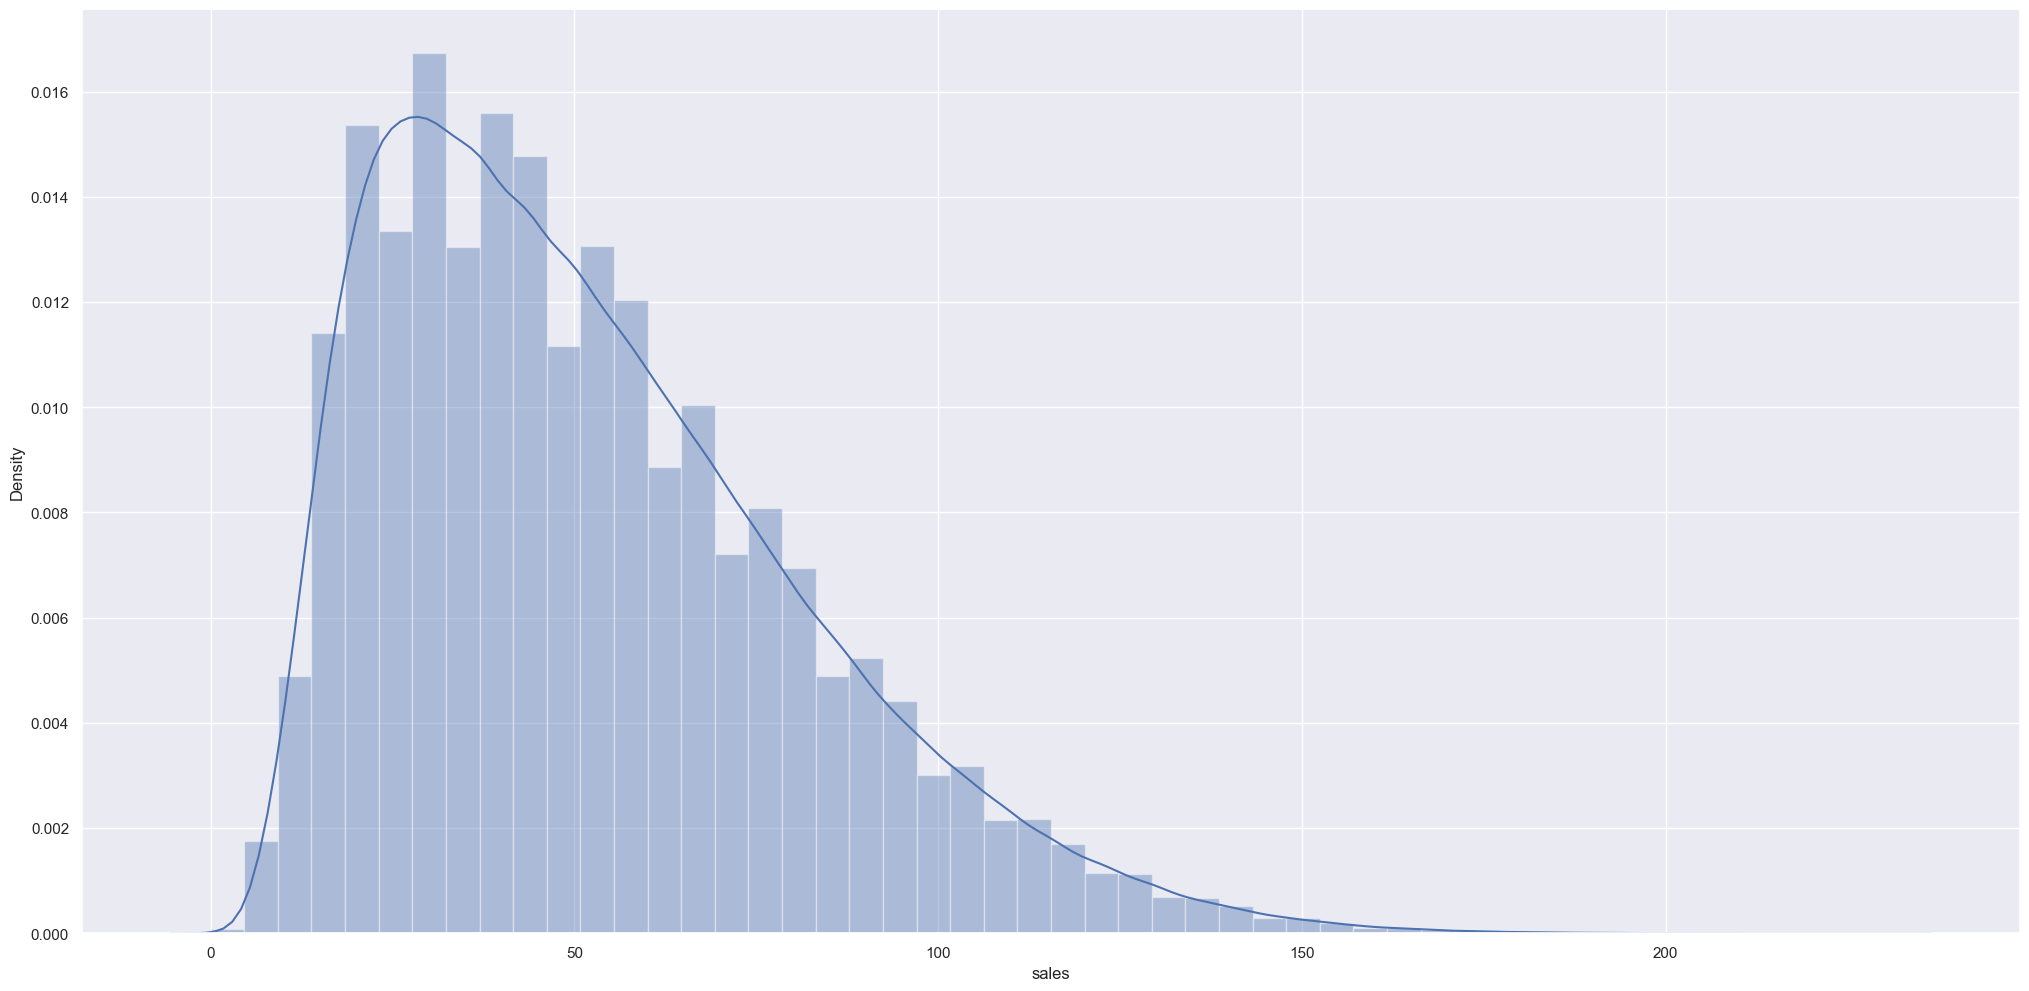

In [17]:
sns.distplot( df1['sales'] )

# 2.0 STEP 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

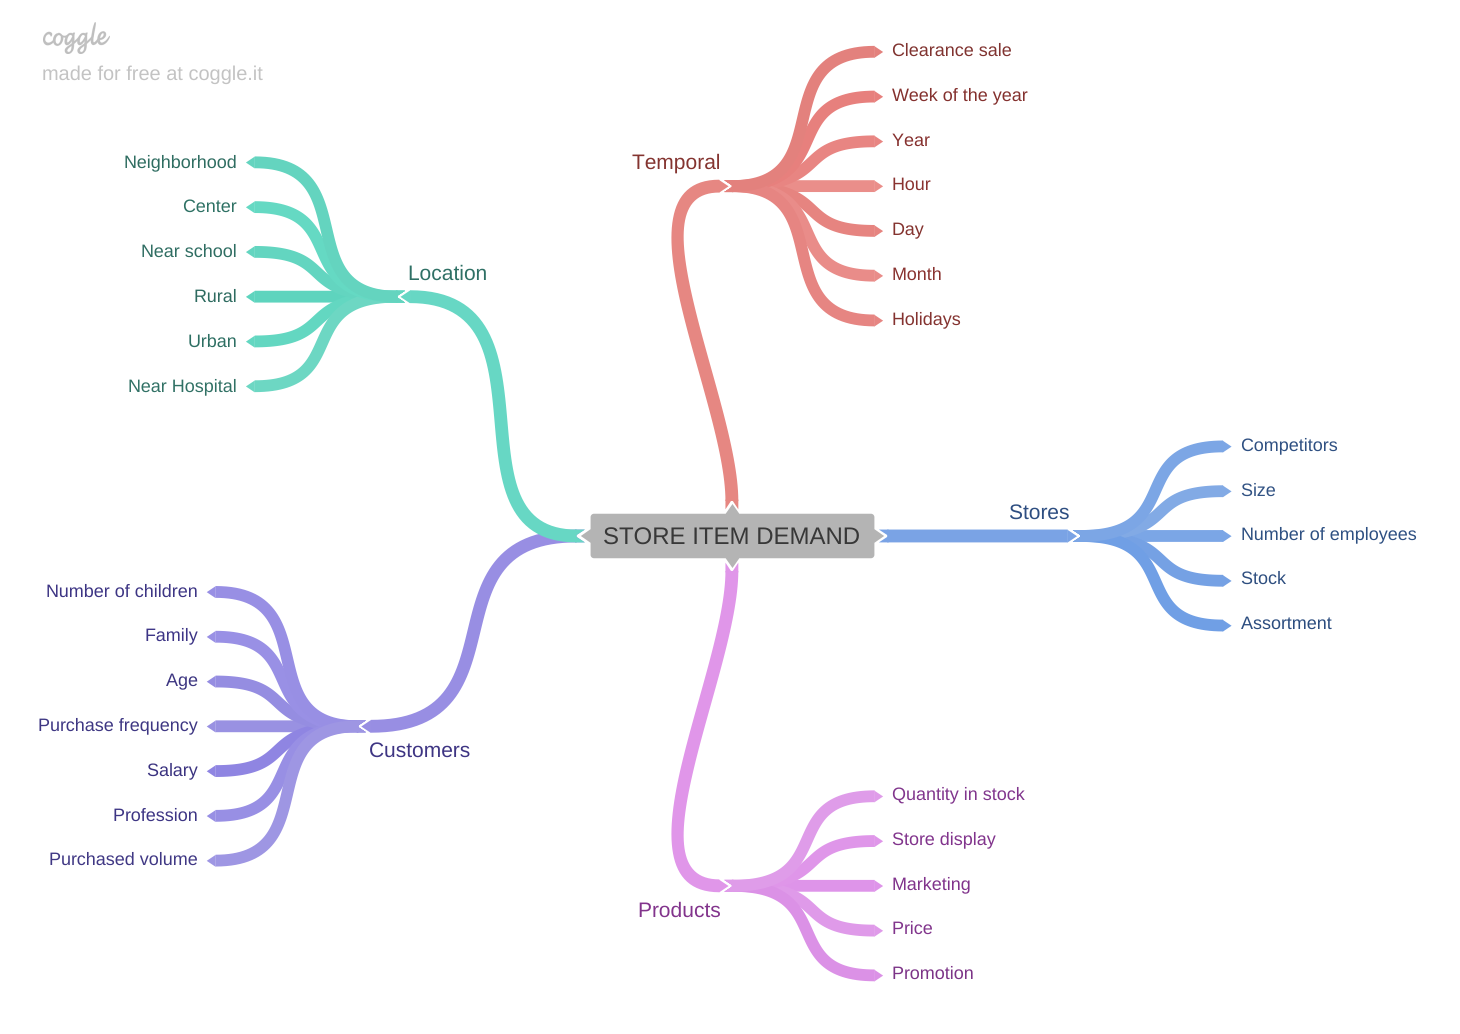

In [19]:
Image( "image/Hyphoteses_Map.png")

## 2.1 Creation of Hyphoteses

### 2.1.1. Shop Hypotheses

**1.** Stores with more employees should sell more items.

**2.** Stores with greater inventory capacity should sell more items.

**3.** Larger stores should sell more items.

**4.** Stores with closer competitors should sell less items.

**5.** Stores with longer competitors should sell more items.

### 2.1.2. Product Hypotheses

**1.** Stores that invest more in Marketing should sell more items.

**2.** Stores with greater product exposure should sell more items.

**3.** Stores with lower prices should sell more items.

**4.** Stores with more aggressive promotions (bigger discounts), should sell more items.

**5.** Stores with active promotions for longer should sell more items.

**6.** Stores with more promotion days should venerate more items.

**7.** Stores with more consecutive promotions should sell more items.

### 2.1.3 Time Hyphoteses

**1.** Stores open during the Christmas holiday should sell more items.

**2.** Stores should be selling more items over the years.

**3.** Stores should sell more items in the second half of the year.

**4.** Stores should sell more items after the 10th of each month.

**5.** Stores should sell less items on weekends.

**6.** Stores should sell less items during school holidays.

## 2.2 Final List of Hyphoteses

In [20]:
# As we only have information on sales dates in this dataset, I will use only the time hypothesis items in the final hypothesis list.

**1.** Stores should be selling more items over the years.

**2.** Stores should sell more items in the second half of the year.

**3.** Stores should sell more items after the 10th of each month.

**4.** Stores should sell less items on weekends.

## 2.3 Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# day of week
df2['day_of_week'] = df2['date'].dt.dayofweek

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [22]:
df2.sample(5).T

,288412,834411,10903,171539,147479
date,2017-09-27 00:00:00,2017-10-22 00:00:00,2017-11-09 00:00:00,2017-09-18 00:00:00,2016-10-31 00:00:00
store,8,7,6,4,1
item,16,46,1,10,9
sales,25,51,18,71,42
year,2017,2017,2017,2017,2016
month,9,10,11,9,10
day,27,22,9,18,31
day_of_week,2,6,3,0,0
week_of_year,39,42,45,38,44
year_week,2017-39,2017-42,2017-45,2017-38,2016-44


# 3.0 STEP 03 - VARIABLE FILTERING

In [23]:
df3 = df2.copy()

In [24]:
df3.head()

,date,store,item,sales,year,month,day,day_of_week,week_of_year,year_week
0,2013-01-01,1,1,13,2013,1,1,1,1,2013-00
1,2013-01-02,1,1,11,2013,1,2,2,1,2013-00
2,2013-01-03,1,1,14,2013,1,3,3,1,2013-00
3,2013-01-04,1,1,13,2013,1,4,4,1,2013-00
4,2013-01-05,1,1,10,2013,1,5,5,1,2013-00


## 3.1 Line Filtering

In [25]:
df3 = df3[df3['sales'] > 0]

## 3.2 Column Filtering

In [26]:
# There isn't any columns desnecessary in this dataset.

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [27]:
df4 = df3.copy()

## 4.1 Univariable Analysis

### 4.1.1 Response Variable

<AxesSubplot: xlabel='sales'>

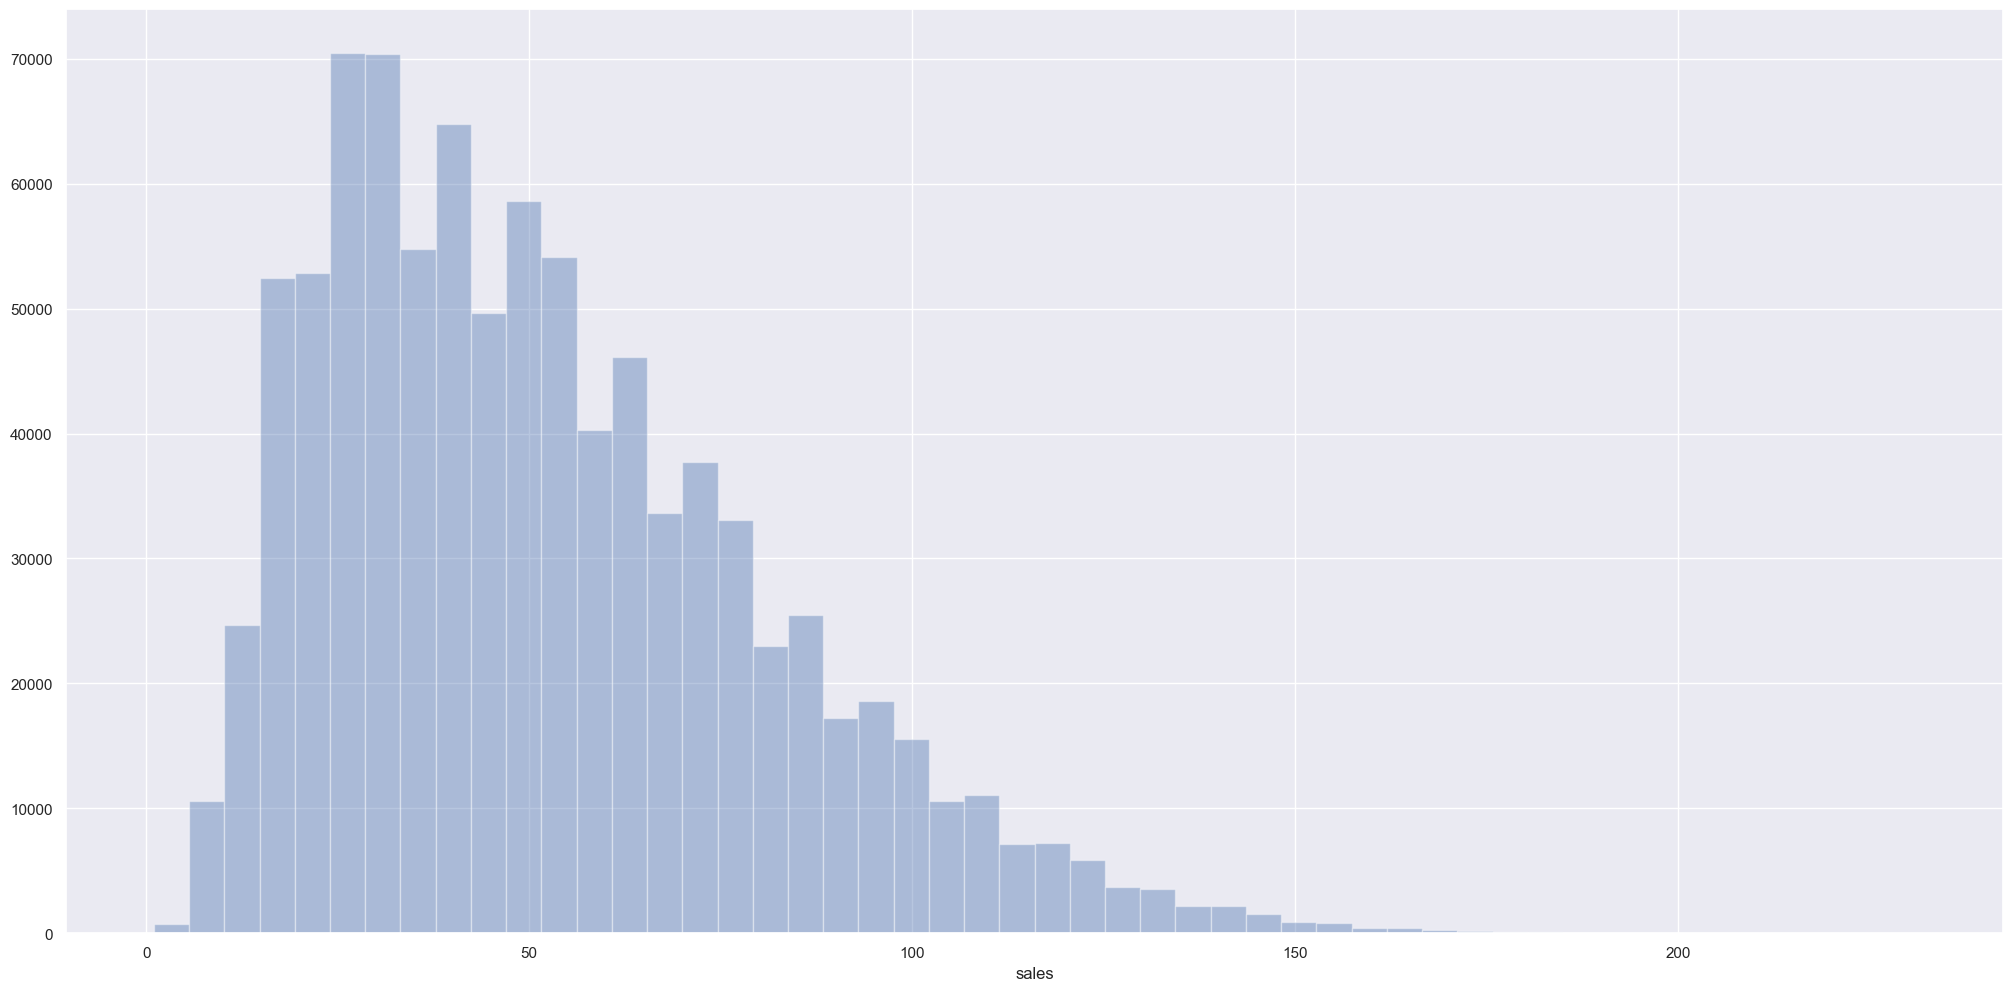

In [28]:
sns.distplot( df4['sales'], kde=False )

### 4.1.2. Numerical Variable

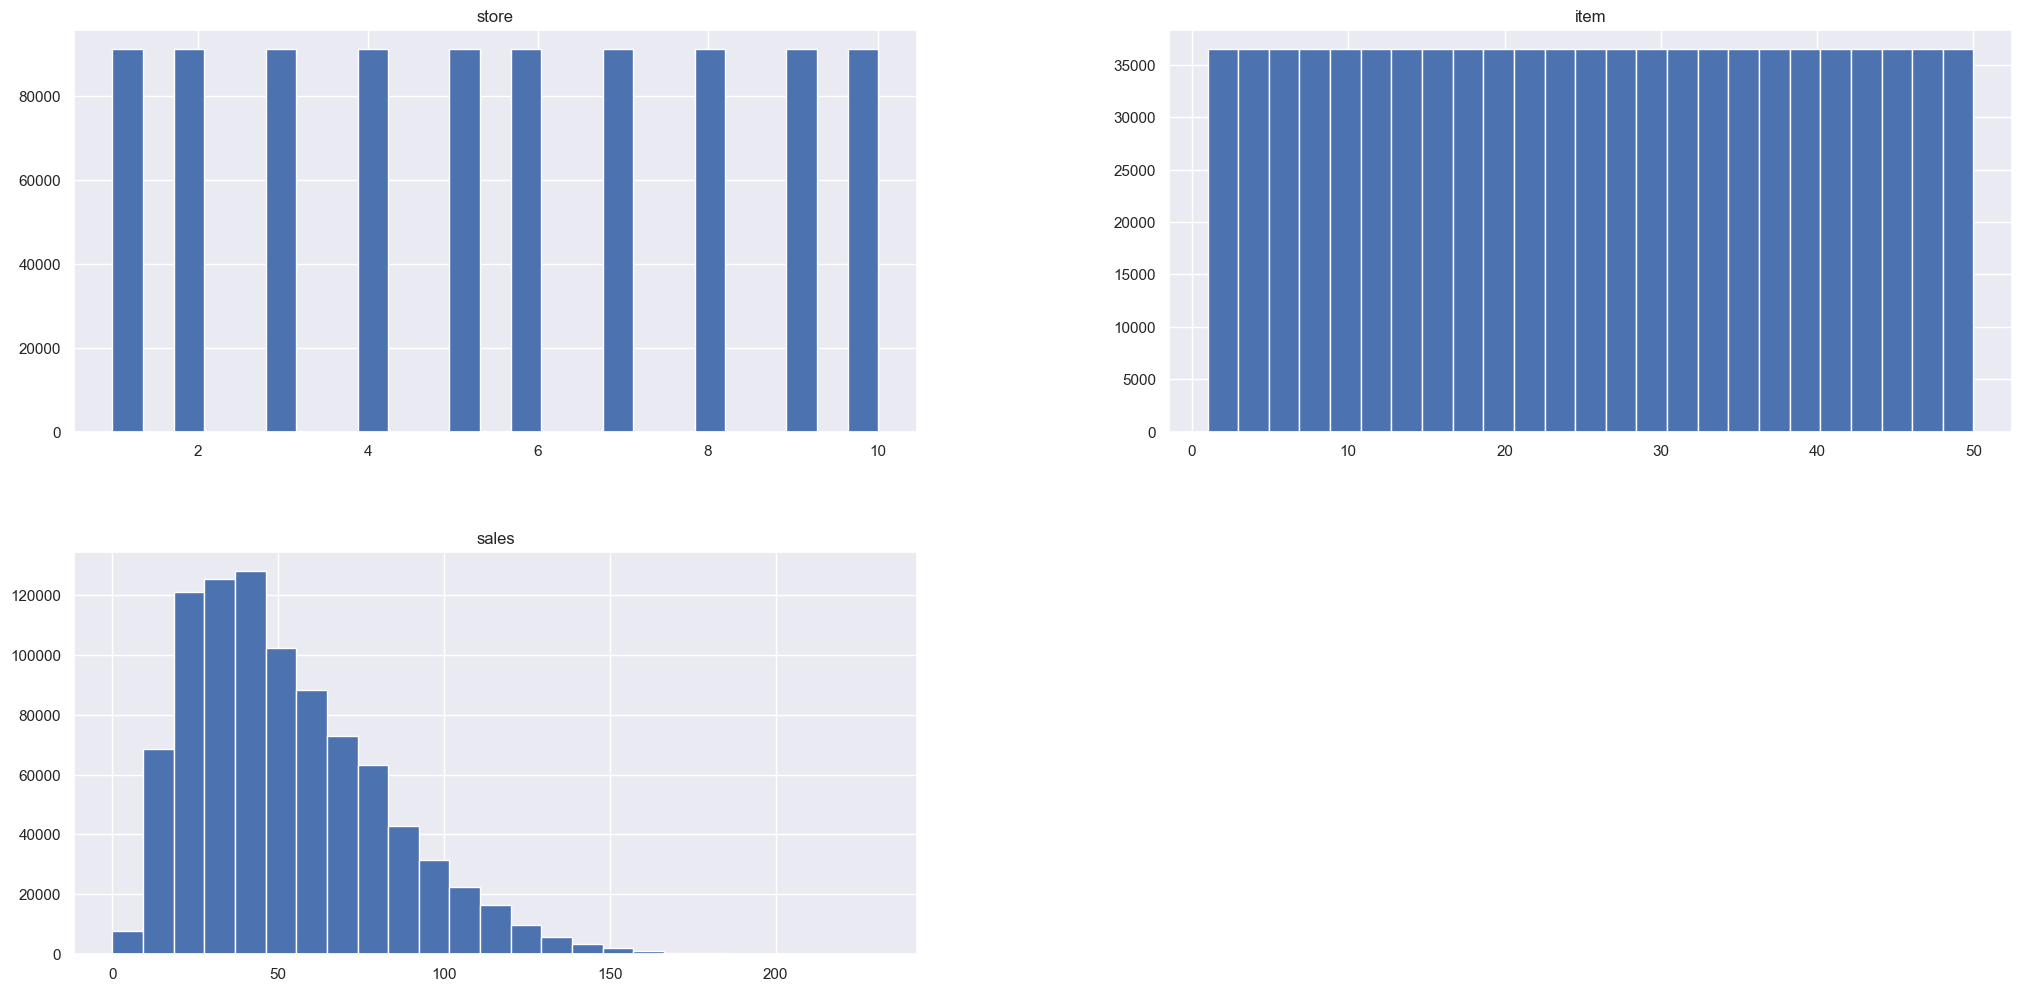

In [29]:
num_attributes.hist( bins=25 );

### 4.1.3. Categorical Variable

In [30]:
# There isn't categorical variable.

## 4.2. Bivariate Analysis

### H1. Stores should be selling more items over the years.
**TRUE** Stores selling more items over the years.

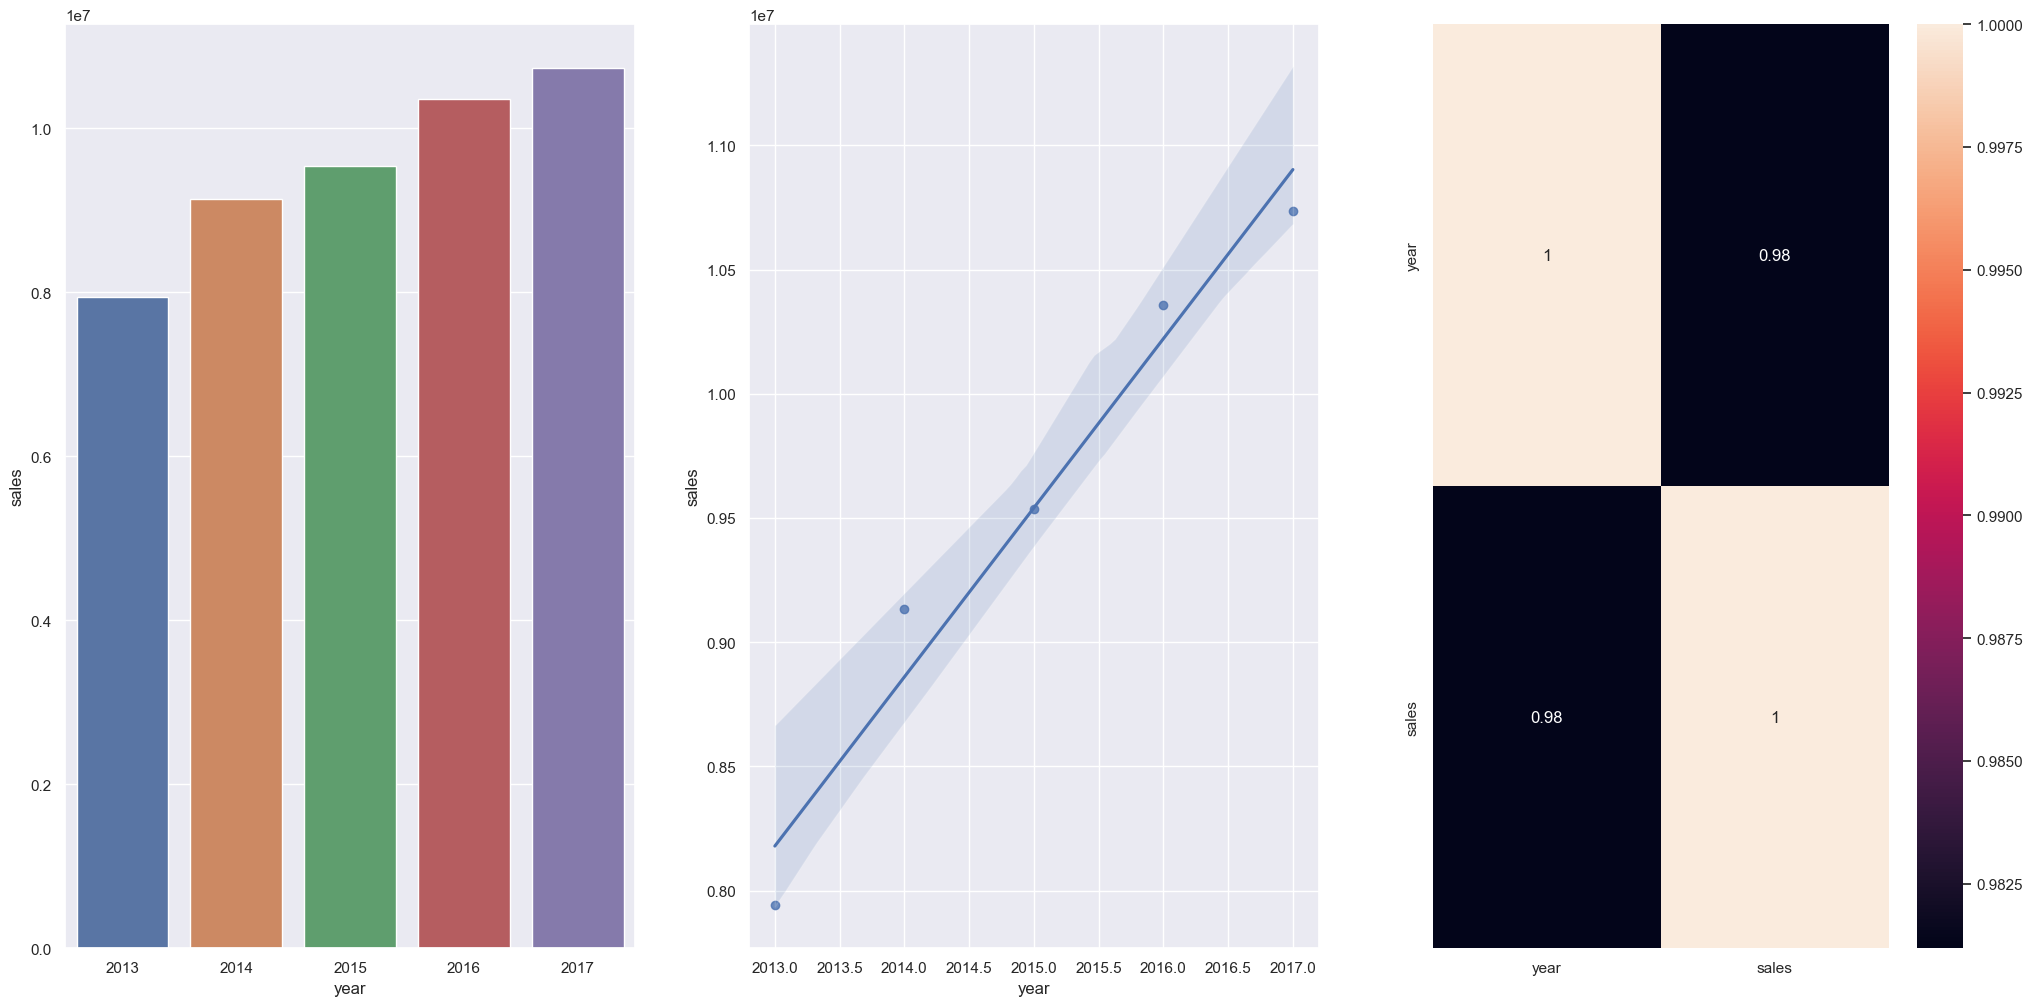

In [31]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H2. Stores should sell more items in the second half of the year.
**TRUE** Stores sell more items in the second half of the year.

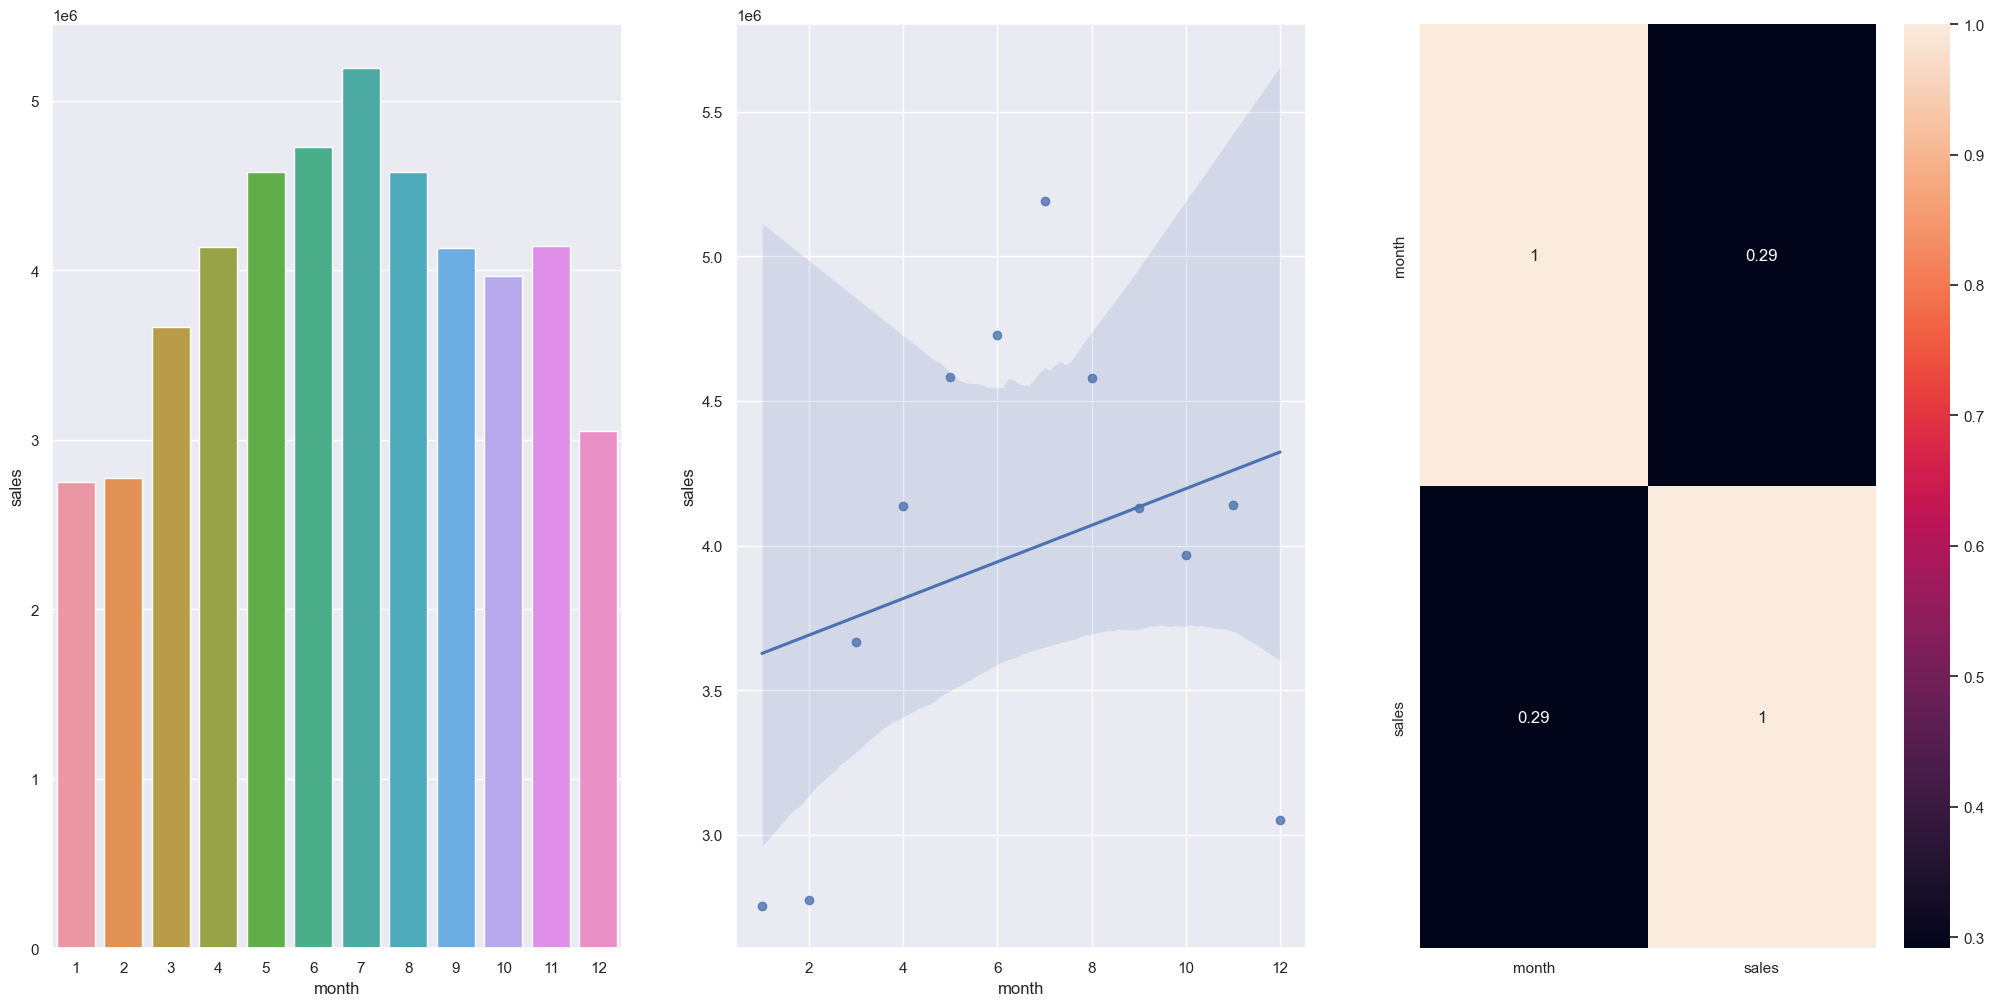

In [32]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Stores should sell more items after the 10th of each month.
**TRUE** Stores sell more items after the 10th of each month.

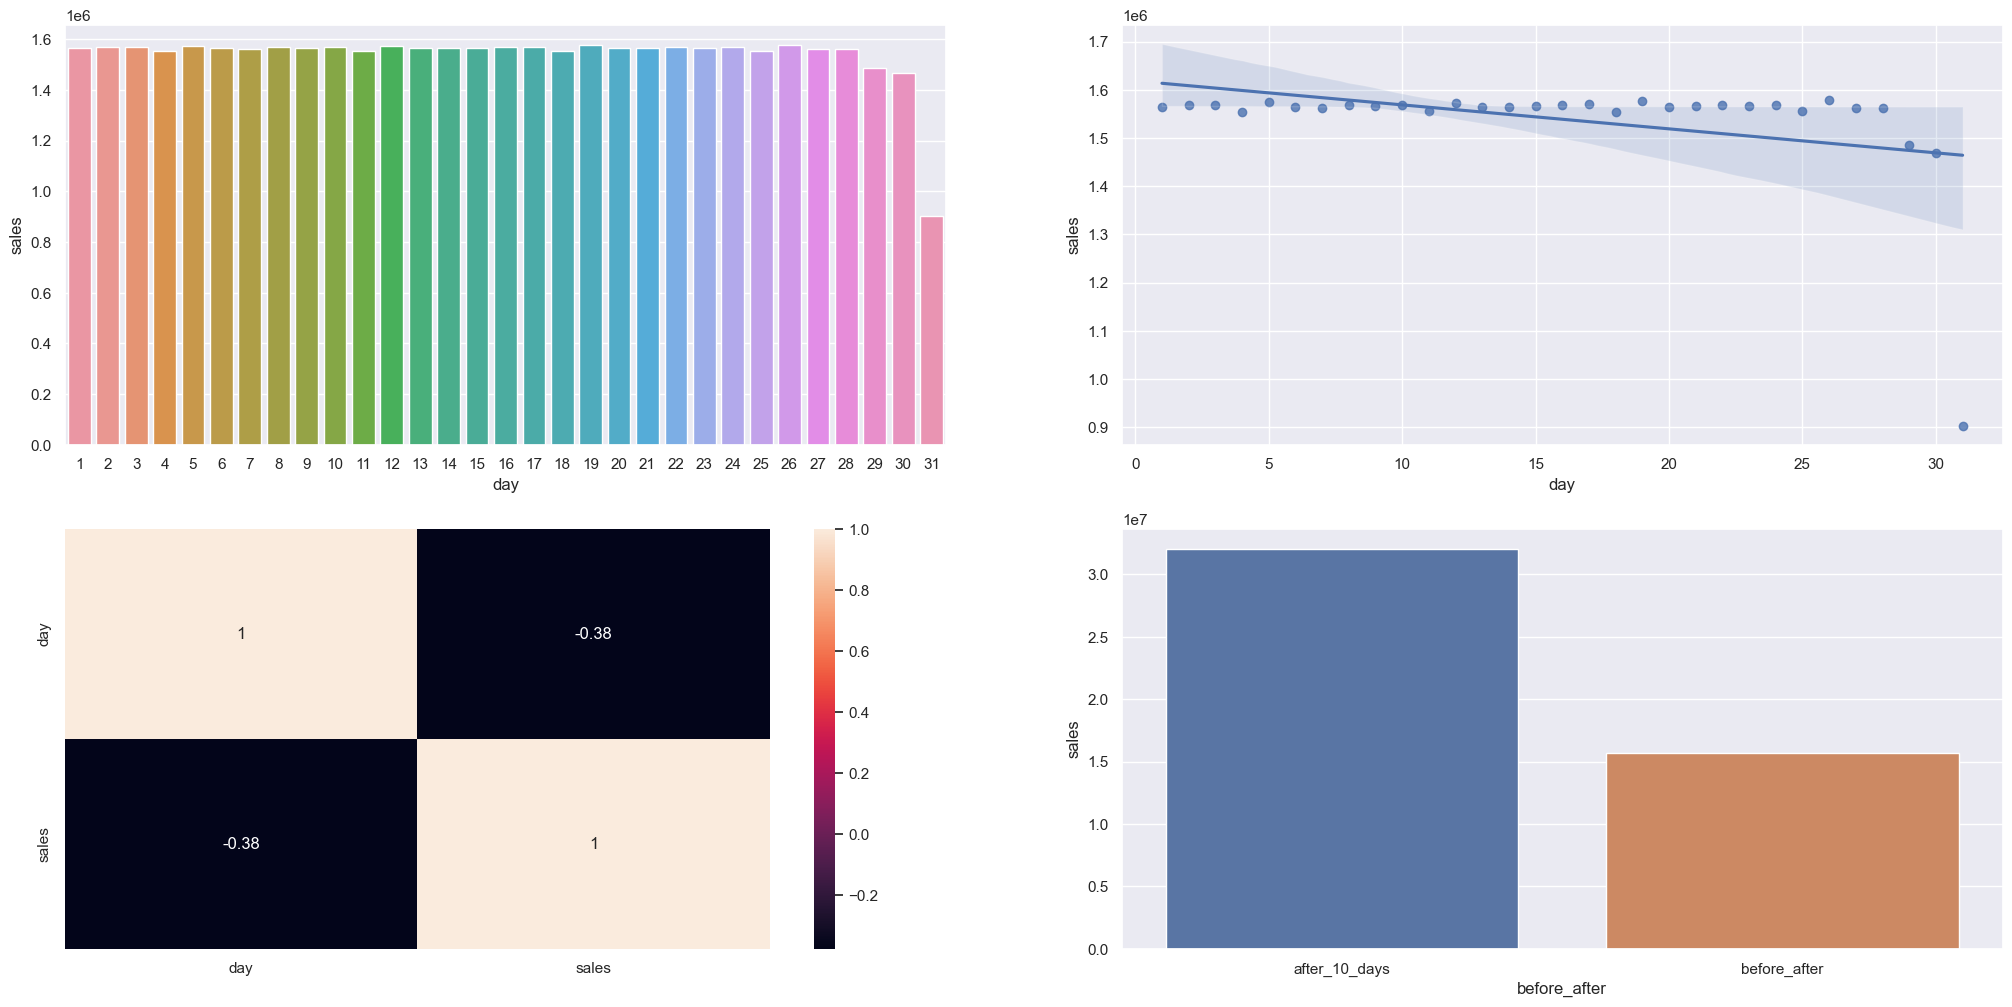

In [33]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_after' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### H4. Stores should sell less items on weekends.
**TRUE** Stores sell less items on weekends.

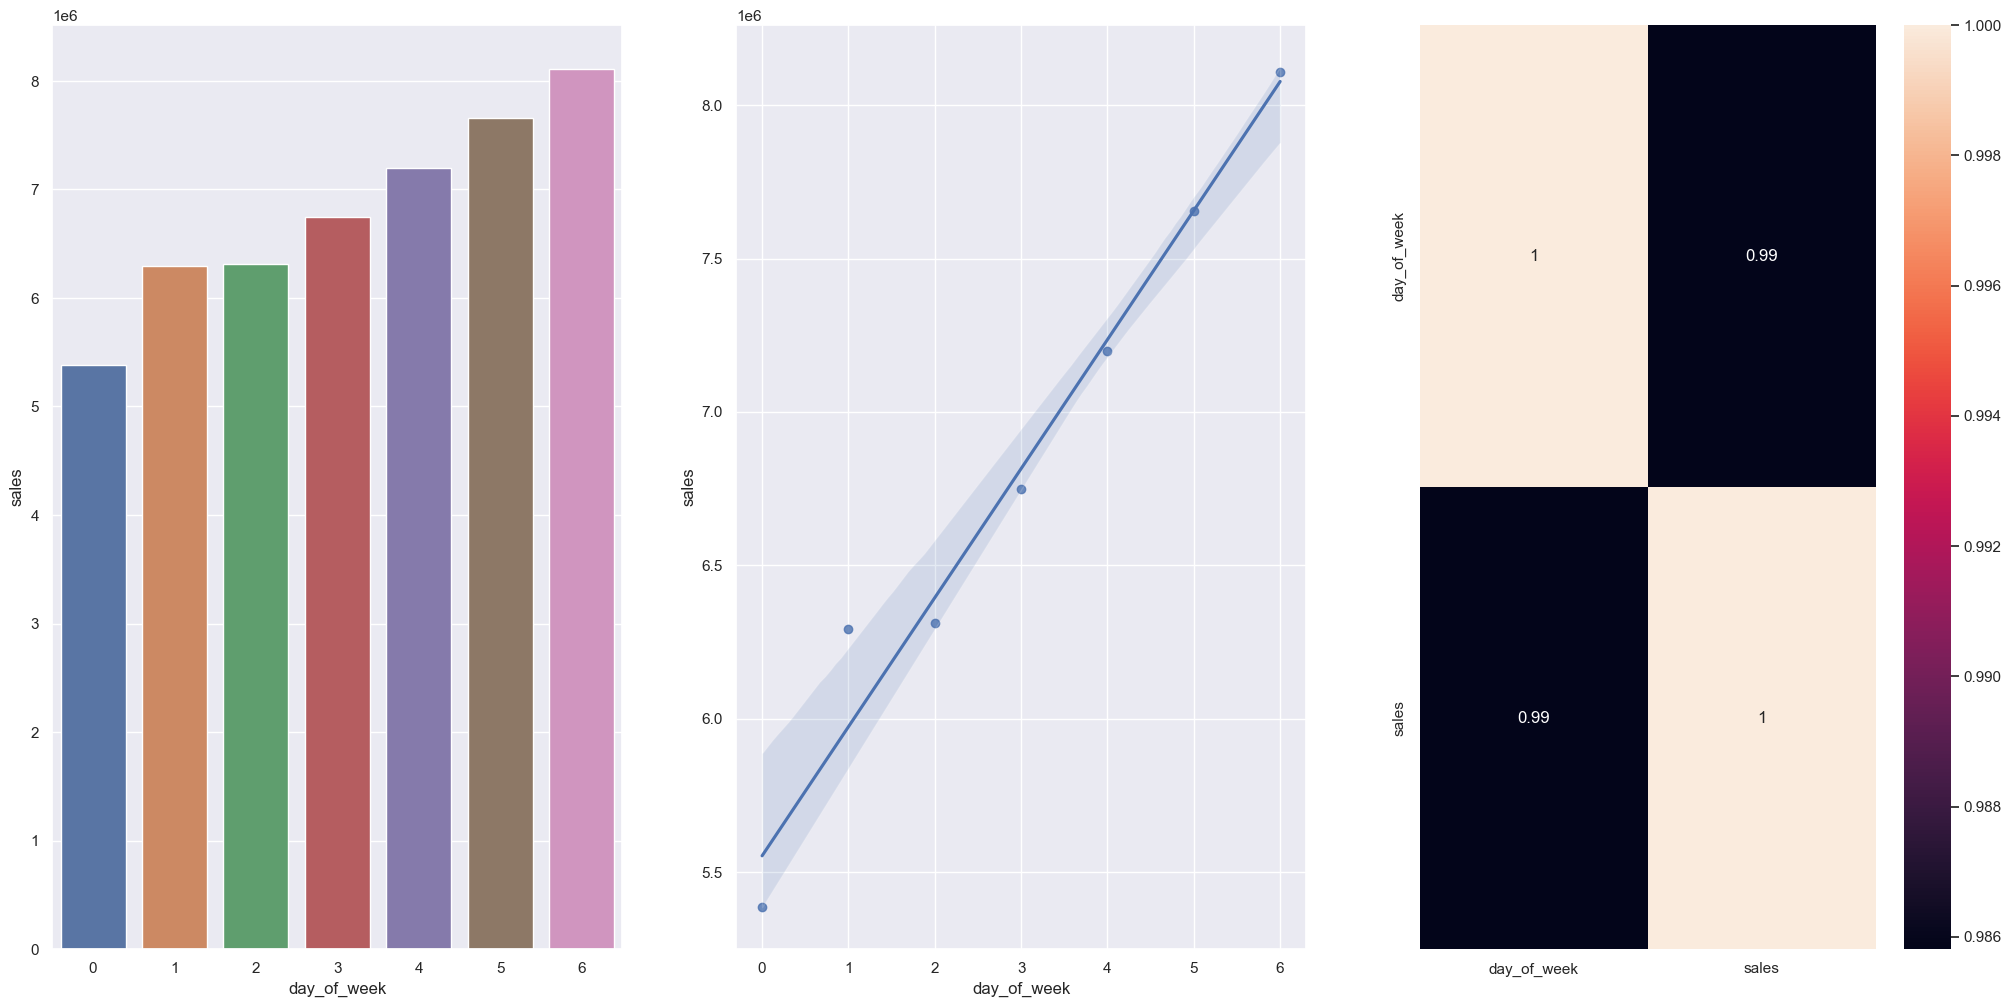

In [34]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# The day of the week with Monday=0, Sunday=6.
# Return the day of the week. It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6.

### 4.2.1 Hypothesis Summary

In [35]:
tab = [['Hyphoteses', 'Conclusion', 'Relevance'],
       ['H1', 'True', 'High'],
       ['H2', 'True', 'Medium'],
       ['H3', 'True', 'Medium'],
       ['H4', 'True', 'High']
      ]
print( tabulate( tab, headers='firstrow' ) )

Hyphoteses    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            True          Medium
H3            True          Medium
H4            True          High


## 4.3. Multivariate Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot: >

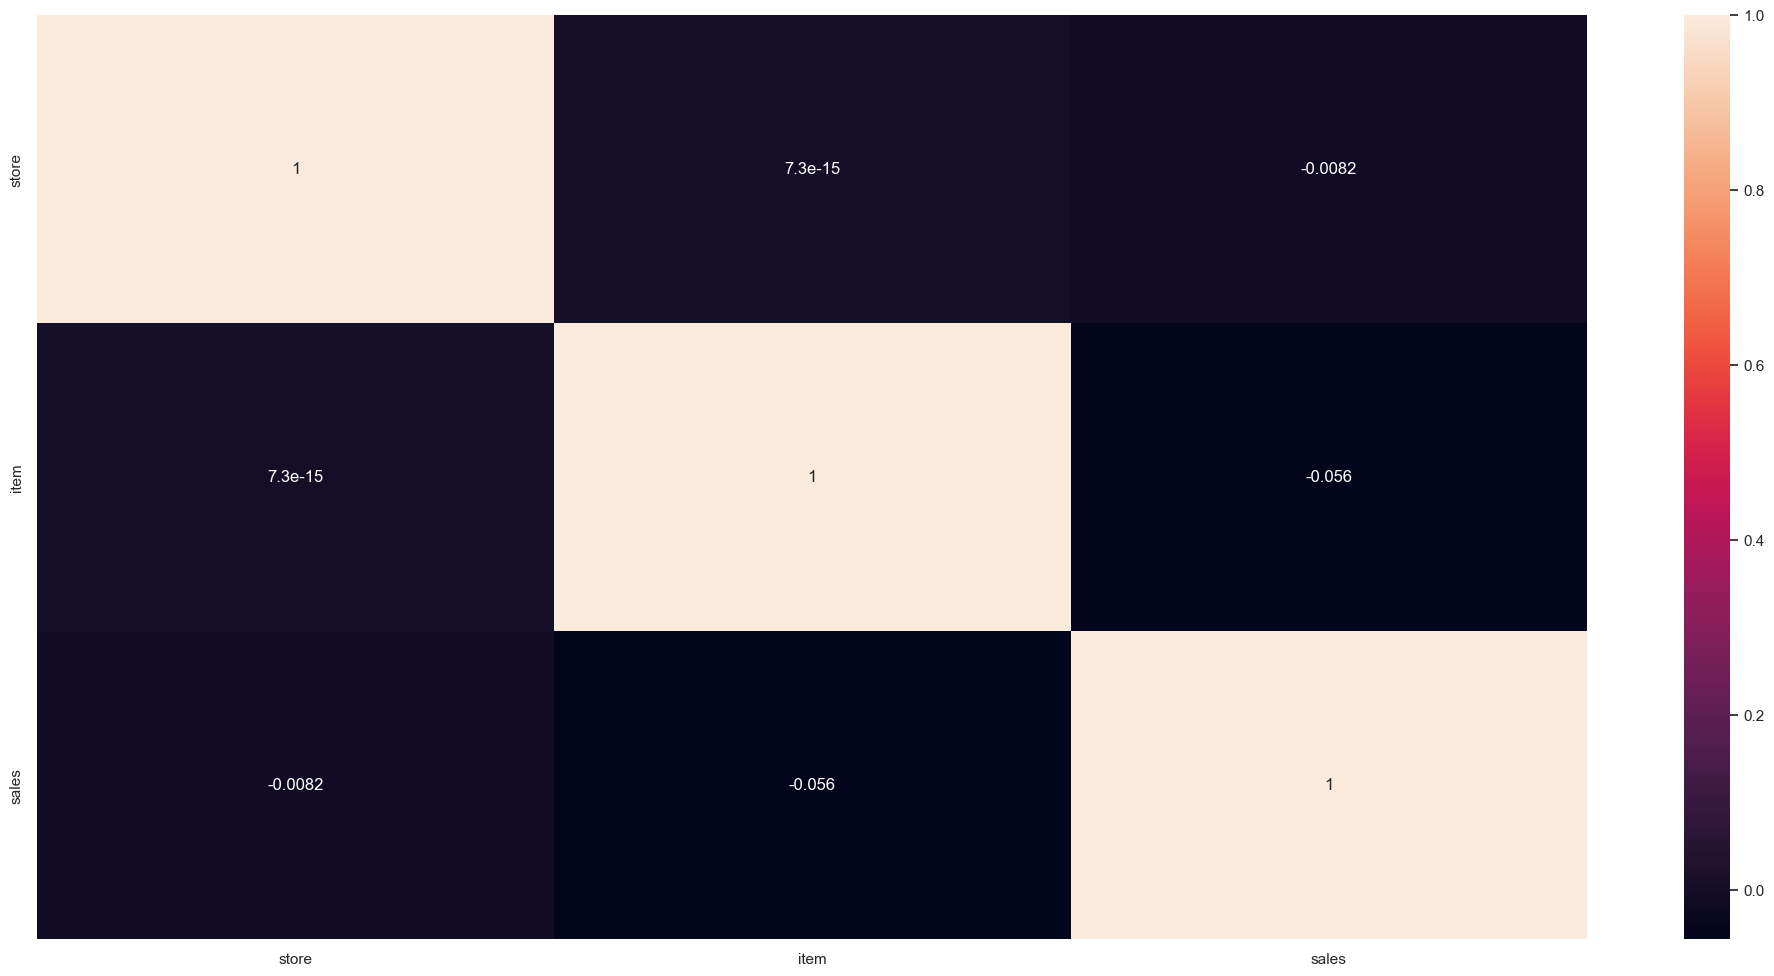

In [36]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

### 4.3.2. Categorical Attributes

In [37]:
# There isn't Categorical Variable.

# 5.0 STEP 05 - DATA PREPARATION

In [38]:
df5 = df4.copy()

## 5.1 Normalization

In [39]:
# Go to 4.1.2. Numerical variable to see if there is any Gaussian distribution

# We don't have any data distribution like a Gaussian.

## 5.2 Rescaling

In [40]:
a = df5.select_dtypes( include=['int64', 'float64'] )

In [41]:
a.sample()

,store,item,sales,year,month,day,day_of_week,week_of_year
174899,6,10,61,2016,11,30,2,48


<AxesSubplot: >

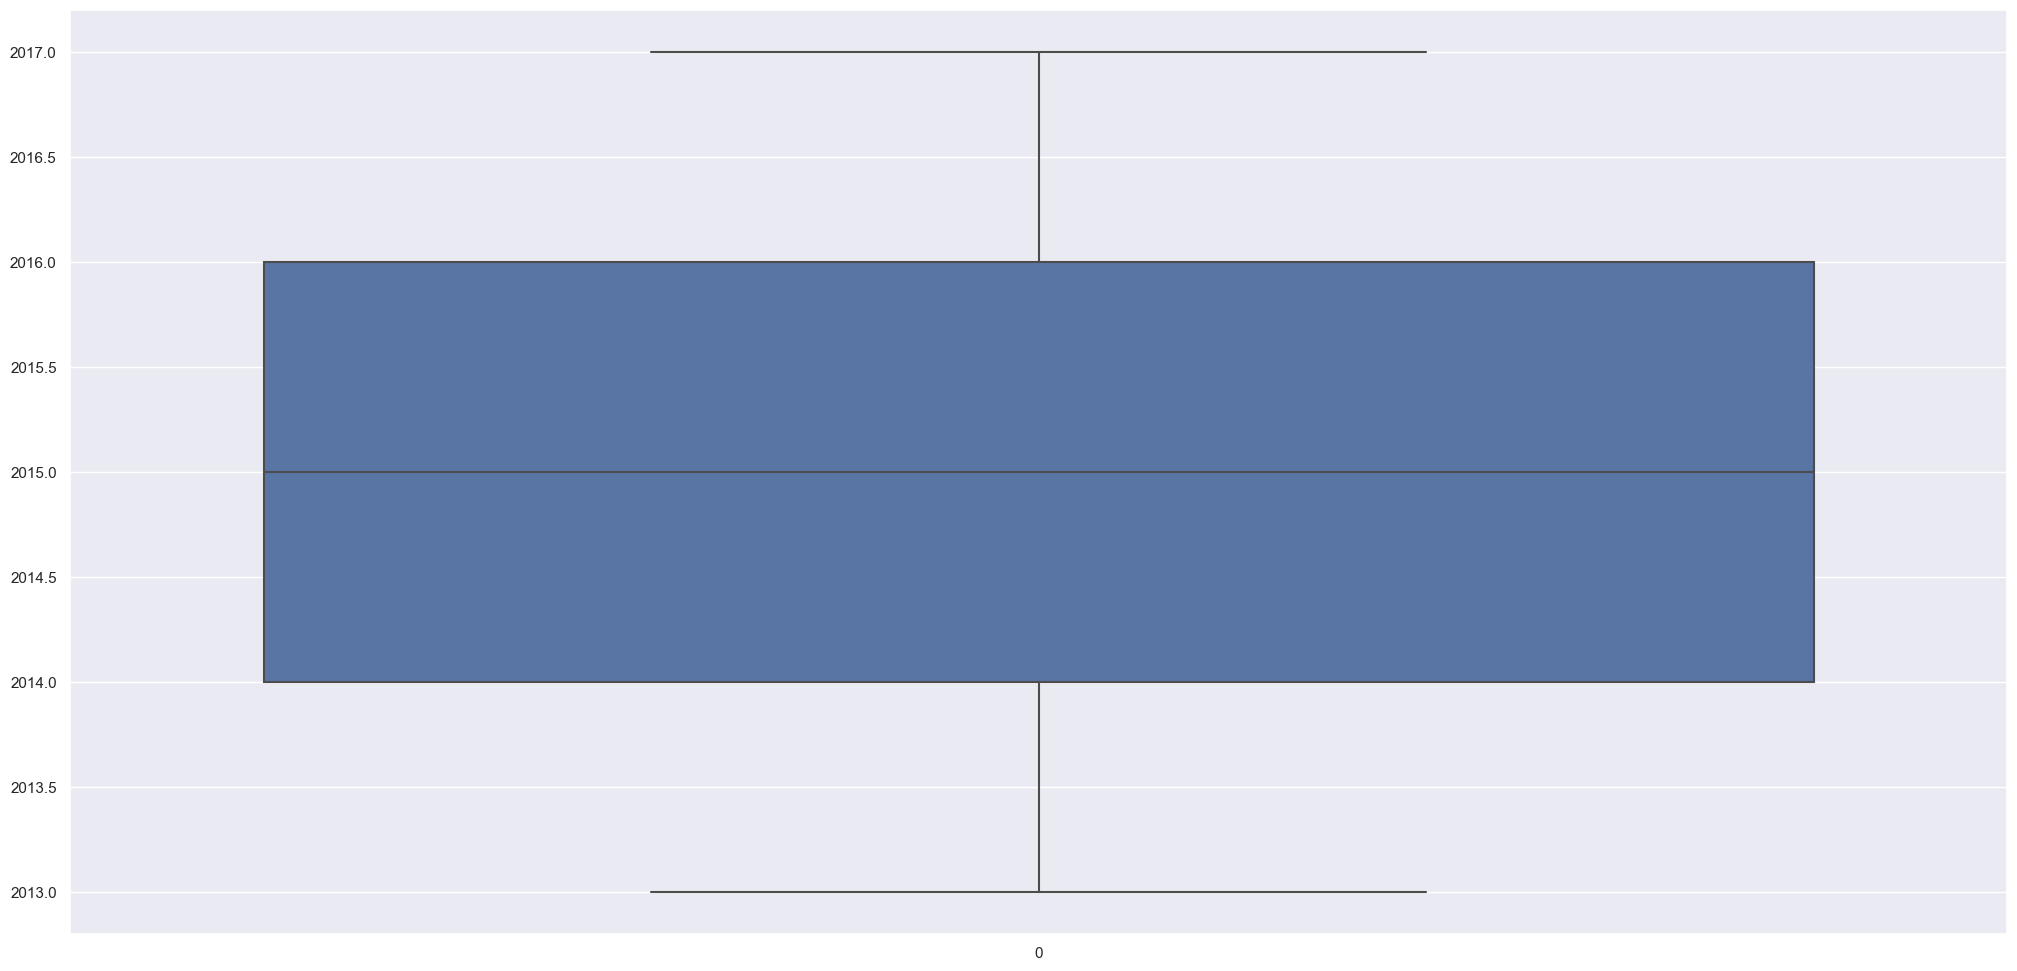

In [42]:
sns.boxplot( df5['year'] )

In [43]:
mms = MinMaxScaler()

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

<AxesSubplot: >

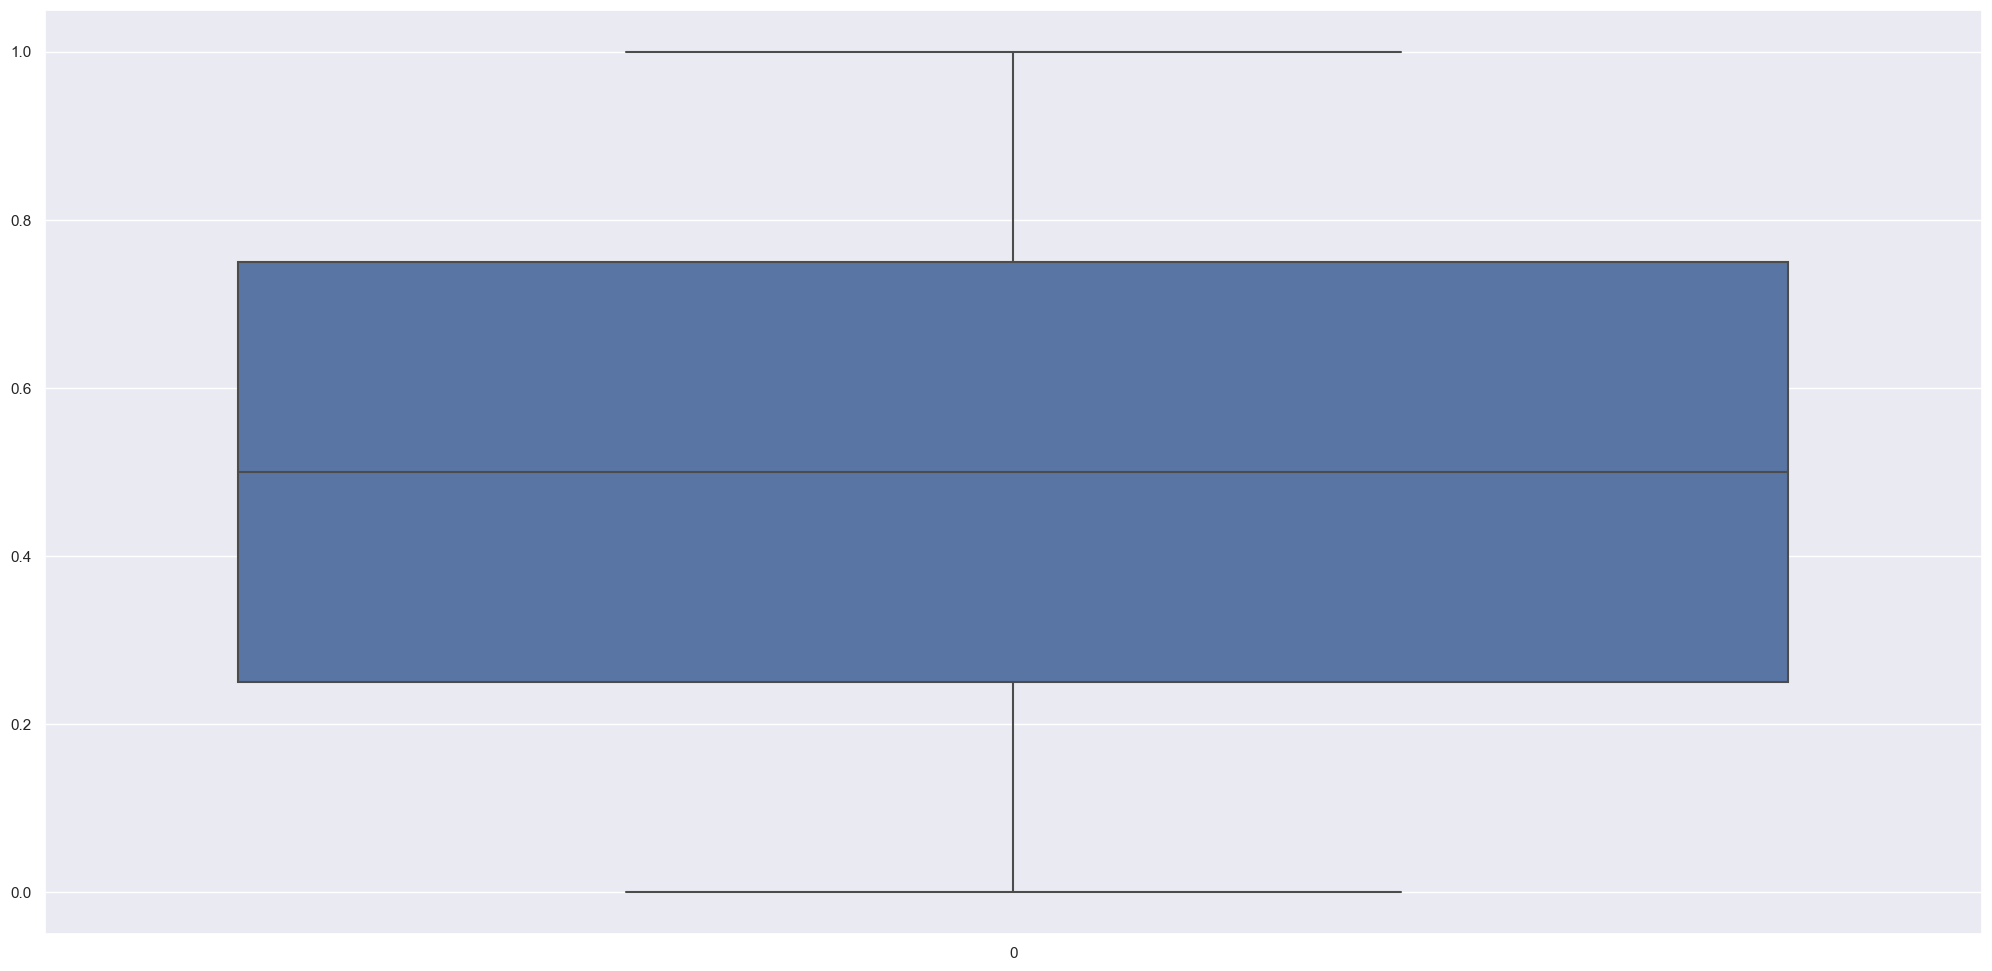

In [44]:
sns.boxplot( df5['year'] )

## 5.3 Transformation

### 5.3.1 Encoding

In [45]:
# We don't have categorical values to apply encoding.

### 5.3.2 Response Variable Transformation

In [46]:
df5['sales'] = np.log1p( df5['sales'] )

<AxesSubplot: xlabel='sales', ylabel='Density'>

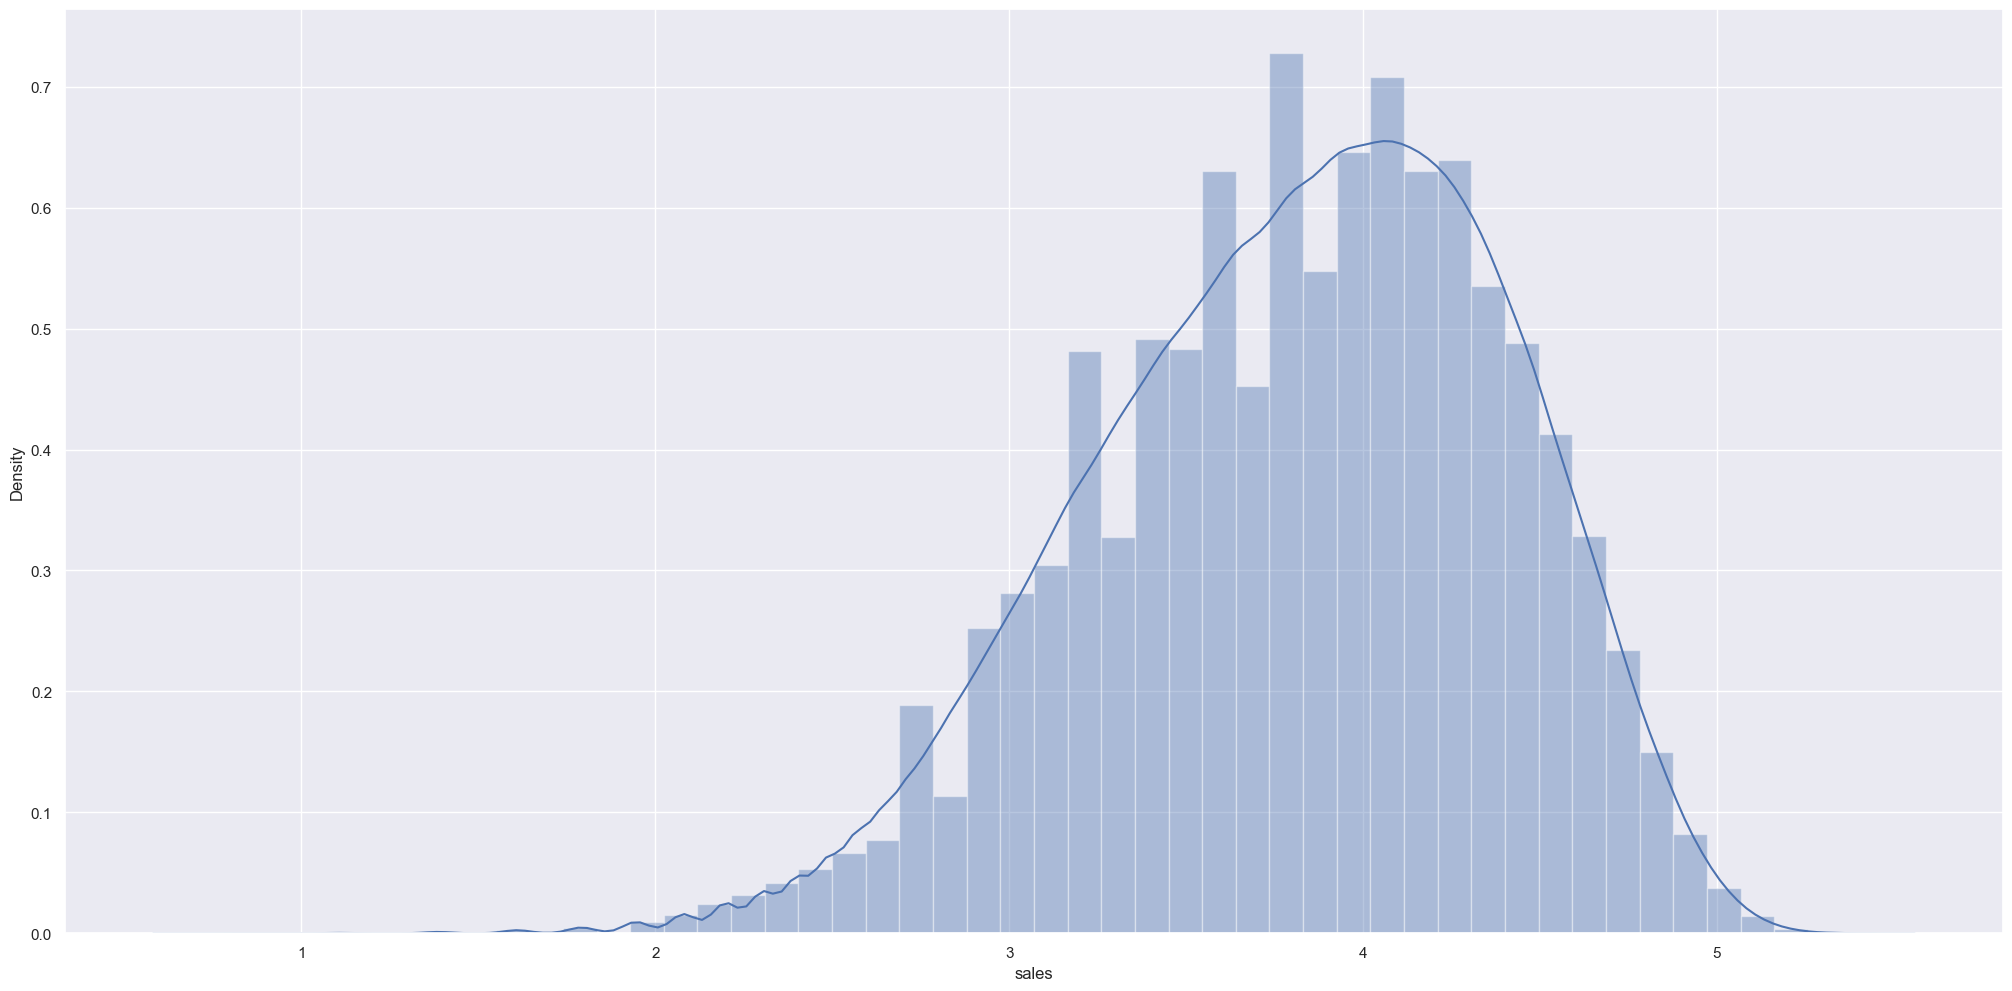

In [47]:
sns.distplot( df5['sales'] )

### 5.3.3. Nature Transformation

In [48]:
# My goal here is to take the numerical data and transform its natures to cyclical.
# The cyclical variable in this dataset are "day_of_week", "month", "day" and "week of year".

# I am not going to go into mathematical details about the method used to turn numeric or categorical variables into cyclical ones, but I am going to give you an idea of what will be done.
# Cyclic behavior looks like a circle. The code will place the values within each variable in this circle and for this the concepts of sine and cosine will be used. 
# Note that at the end of the formula I divide by the amount of cyclic values present in each variable.

In [49]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [50]:
df5.sample(5)

,date,store,item,sales,year,month,day,day_of_week,week_of_year,year_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
152188,2014-09-23,4,9,4.127134,0.25,9,23,1,39,2014-38,0.781831,0.623490,-1.000000e+00,-1.836970e-16,-9.945219e-01,0.104528,-1.000000,-1.836970e-16
479434,2015-10-20,3,27,3.465736,0.50,10,20,1,43,2015-42,0.781831,0.623490,-8.660254e-01,5.000000e-01,-8.660254e-01,-0.500000,-0.885456,4.647232e-01
249065,2014-12-31,7,14,3.610918,0.25,12,31,2,1,2014-52,0.974928,-0.222521,-2.449294e-16,1.000000e+00,2.079117e-01,0.978148,0.120537,9.927089e-01
368713,2017-08-15,2,21,3.988984,1.00,8,15,1,33,2017-33,0.781831,0.623490,-8.660254e-01,-5.000000e-01,1.224647e-16,-1.000000,-0.748511,-6.631227e-01
709071,2014-08-07,9,39,3.951244,0.25,8,7,3,32,2014-31,0.433884,-0.900969,-8.660254e-01,-5.000000e-01,9.945219e-01,0.104528,-0.663123,-7.485107e-01


# 6.0 STEP 06 - FEATURE SELECTION

In [51]:
df6 = df5.copy()

In [52]:
df6.shape

(912999, 18)

## 6.1. Split dataframe into training and test dataset

In [53]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [54]:
df6.sample()

,date,store,item,sales,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
156,2013-06-06,1,1,2.302585,0.0,0.433884,-0.900969,1.224647e-16,-1.0,0.951057,0.309017,0.354605,-0.935016


In [55]:
# As we will predict the next 3 months, I will use the calculation (30*3) to subtract from the max date inside dataset.
df6[['store', 'item', 'date']].groupby( ['store', 'item'] ).max().reset_index()['date'][0] - datetime.timedelta( days=30*3 )

Timestamp('2017-10-02 00:00:00')

In [56]:
# training dataset
X_train = df6[df6['date'] < '2017-10-02']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2017-10-02']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date']. min() ) )
print( 'Training Max Date: {}'.format( X_train['date']. max() ) )

print( '\nTest Min Date: {}'.format( X_test['date']. min() ) )
print( 'Test Max Date: {}'.format( X_test['date']. max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2017-10-01 00:00:00

Test Min Date: 2017-10-02 00:00:00
Test Max Date: 2017-12-31 00:00:00


## 6.2. Boruta as Feature Selector

In [57]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegression
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	3


In [69]:
features = ['date', 'store', 'item', 'sales', 'year', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'week_of_year_sin', 'week_of_year_cos']

In [70]:
feature_ranks = list(zip(features, 
                         boruta.ranking_, 
                         boruta.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: date                      Rank: 1,  Keep: True
Feature: store                     Rank: 1,  Keep: True
Feature: item                      Rank: 1,  Keep: True
Feature: sales                     Rank: 1,  Keep: True
Feature: year                      Rank: 1,  Keep: True
Feature: day_of_week_sin           Rank: 1,  Keep: True
Feature: day_of_week_cos           Rank: 2,  Keep: False
Feature: month_sin                 Rank: 4,  Keep: False
Feature: month_cos                 Rank: 3,  Keep: False
Feature: day_sin                   Rank: 1,  Keep: True
Feature: day_cos                   Rank: 1,  Keep: True


### 6.2.1. Best Feature from Boruta

In [71]:
cols_selected = boruta.support_.tolist()

# best feature
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [58]:
cols_selected_boruta

['store',
 'item',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'week_of_year_sin',
 'week_of_year_cos']

In [59]:
cols_not_selected_boruta

['day_cos', 'day_sin', 'month_cos']

## 6.3. Manual Feature Selection

In [56]:
cols_selected_boruta = [
     'store',
     'item',
     'year',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [57]:
cols_selected_boruta

['store',
 'item',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [58]:
cols_selected_boruta_full

['store',
 'item',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 STEP 07 - MACHINE LEARNING MODELLING

In [59]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparartion
X_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [117]:

aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'item', 'sales']].groupby( ['store', 'item'] ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on=['store', 'item'] )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,10.026081,1.19464,13.267076


## 7.2 Linear Regression Model

In [118]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,22.619169,0.509636,29.016195


### 7.2.1 Linear Regression Model - Cross Validation

In [119]:
lr_result_cv = cross_validation( X_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,24.04 +/- 3.19,0.53 +/- 0.02,30.0 +/- 3.78


## 7.3 Linear Regression Regularized Model

In [120]:
# model
lrr = Lasso( alpha=0.00001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,22.618895,0.509635,29.015623


### 7.3.1 Linear Regression - Lasso - Cross Validation

In [121]:
lrr_result_cv = cross_validation( X_training, 5, 'Linear Regression - Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,24.04 +/- 3.19,0.53 +/- 0.02,30.01 +/- 3.78


## 7.4 Random Forest Regressor

In [132]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,7.042839,0.147583,9.203405


### 7.4.1. Random Forest Regressor - Cross Validation

In [70]:
rf_result_cv = cross_validation( X_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,7.26 +/- 0.42,0.14 +/- 0.01,9.47 +/- 0.53


## 7.5. XGBoost Regressor

In [71]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6.411159,0.13124,8.47306


### 7.5.1. XGBoost Regressor - Cross Validation

In [72]:
xgb_result_cv = cross_validation( X_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv   


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6.55 +/- 0.44,0.13 +/- 0.01,8.62 +/- 0.59


## 7.6. Prophet

In [60]:
prophet_df = X_train[ cols_selected_boruta_full ]
prophet_df = prophet_df.rename(columns={'date':'ds', 'sales':'y'})
prophet_df.head()

,store,item,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,ds,y
0,1,1,0.0,0.781831,0.623490,0.5,0.866025,0.120537,0.992709,2013-01-01,2.639057
1,1,1,0.0,0.974928,-0.222521,0.5,0.866025,0.120537,0.992709,2013-01-02,2.484907
2,1,1,0.0,0.433884,-0.900969,0.5,0.866025,0.120537,0.992709,2013-01-03,2.708050
3,1,1,0.0,-0.433884,-0.900969,0.5,0.866025,0.120537,0.992709,2013-01-04,2.639057
4,1,1,0.0,-0.974928,-0.222521,0.5,0.866025,0.120537,0.992709,2013-01-05,2.397895


In [61]:
from prophet import Prophet

playoffs = pd.DataFrame({
        'holiday': 'playoff',
        'ds': pd.to_datetime(['2013-07-12', '2014-07-12', '2014-07-19', '2014-07-02', '2015-07-11', '2016-07-17', '2016-07-24', '2016-07-07','2016-07-24']),
        'lower_window': 0,
        'upper_window': 1
    })

superbowls = pd.DataFrame({
        'holiday': 'superbowl',
        'ds': pd.to_datetime(['2013-01-01', '2013-12-25', '2014-01-01', '2014-12-25','2015-01-01', '2015-12-25','2016-01-01', '2016-12-25', '2017-01-01', '2017-12-25']),
        'lower_window': 0,
        'upper_window': 1
    })
holidays = pd.concat((playoffs, superbowls))
model_prophet = Prophet()
model_prophet.add_seasonality(name='daily', period=60, fourier_order=5)
model_prophet = Prophet(holidays = holidays)
model_prophet.add_country_holidays(country_name='US')
model_prophet.fit(prophet_df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [62]:
test_prophet = X_test
test_prophet = test_prophet.rename(columns={'date':'ds', 'sales':'y'})
test_prophet_fcst = model_prophet.predict(test_prophet)
test_prophet_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),Christmas Day (Observed)_lower,Christmas Day (Observed)_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Independence Day (Observed),Independence Day (Observed)_lower,Independence Day (Observed)_upper,Labor Day,Labor Day_lower,Labor Day_upper,Martin Luther King Jr. Day,Martin Luther King Jr. Day_lower,Martin Luther King Jr. Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Day (Observed),New Year's Day (Observed)_lower,New Year's Day (Observed)_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Veterans Day (Observed),Veterans Day (Observed)_lower,Veterans Day (Observed)_upper,Washington's Birthday,Washington's Birthday_lower,Washington's Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,playoff,playoff_lower,playoff_upper,superbowl,superbowl_lower,superbowl_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-10-02,3.951398,3.109855,4.397565,3.951398,3.951398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.187254,-0.187254,-0.187254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.219203,-0.219203,-0.219203,0.031949,0.031949,0.031949,0.0,0.0,0.0,3.764143
1,2017-10-02,3.951398,3.112247,4.439722,3.951398,3.951398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.187254,-0.187254,-0.187254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.219203,-0.219203,-0.219203,0.031949,0.031949,0.031949,0.0,0.0,0.0,3.764143
2,2017-10-02,3.951398,3.054771,4.376363,3.951398,3.951398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.187254,-0.187254,-0.187254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.219203,-0.219203,-0.219203,0.031949,0.031949,0.031949,0.0,0.0,0.0,3.764143
3,2017-10-02,3.951398,3.088112,4.426874,3.951398,3.951398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.187254,-0.187254,-0.187254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.219203,-0.219203,-0.219203,0.031949,0.031949,0.031949,0.0,0.0,0.0,3.764143
4,2017-10-02,3.951398,3.073589,4.450812,3.951398,3.951398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.187254,-0.187254,-0.187254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.219203,-0.219203,-0.219203,0.031949,0.031949,0.031949,0.0,0.0,0.0,3.764143


In [63]:
prophet_result = ml_error( 'FB Prophet', np.expm1( test_prophet['y'] ), np.expm1( test_prophet_fcst['yhat']) )
prophet_result

,Model Name,MAE,MAPE,RMSE
0,FB Prophet,23.309601,0.767823,29.930327


## 7.7. Compare Model's Performance

### 7.6.1 Single Performance

In [73]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6.411159,0.131240,8.473060
0,Random Forest Regressor,7.045448,0.147616,9.205986
0,Average Model,10.026081,1.194640,13.267076
0,Linear Regression - Lasso,22.618895,0.509635,29.015623
0,Linear Regression,22.619169,0.509636,29.016195


### 7.6.2. Real Performance - Cross Validation

In [74]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,24.04 +/- 3.19,0.53 +/- 0.02,30.0 +/- 3.78
0,Linear Regression - Lasso,24.04 +/- 3.19,0.53 +/- 0.02,30.01 +/- 3.78
0,Random Forest Regressor,7.26 +/- 0.42,0.14 +/- 0.01,9.47 +/- 0.53
0,XGBoost Regressor,6.55 +/- 0.44,0.13 +/- 0.01,8.62 +/- 0.59


# 8.0 STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [75]:
param = { 
        'n_estimators': [1500, 1700, 2500, 3000, 3500],
        'eta': [0.01, 0.03],
        'max_depth': [3, 5, 9],
        'subsample': [0.1, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.7, 0.9],
        'min_child_weight': [3, 8, 15] 
        }

MAX_EVAL = 5

In [77]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL):
    #chose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( X_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,6.63 +/- 0.3,0.13 +/- 0.01,8.64 +/- 0.39
0,XGBoost Regressor,6.93 +/- 0.39,0.14 +/- 0.02,9.04 +/- 0.51
0,XGBoost Regressor,6.2 +/- 0.37,0.12 +/- 0.01,8.07 +/- 0.45
0,XGBoost Regressor,6.0 +/- 0.46,0.12 +/- 0.01,7.78 +/- 0.58
0,XGBoost Regressor,6.59 +/- 0.3,0.13 +/- 0.01,8.6 +/- 0.38


## 8.2. Final Model

In [78]:

param_tuned = { 
        'n_estimators': 2500,
        'eta': 0.01,
        'max_depth': 3,
        'subsample': 0.7,
        'colsample_bytree': 0.3,
        'min_child_weight': 15
        }

In [79]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                            n_estimators=param_tuned['n_estimators'], 
                            eta=param_tuned['eta'],
                            max_depth=param_tuned['max_depth'],
                            subsample=param_tuned['subsample'],
                            colsample_bytree=param_tuned['colsample_bytree'],
                            min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,5.797117,0.125239,7.532763


In [80]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.007212721037911337

# 9.0 STEP 09 - TRANSLATION AND INTERPRETATION OF THE ERROR

In [1]:
df9 = X_test[ cols_selected_boruta_full ]

## Linear plot

In [129]:
df9_lr = X_test[ cols_selected_boruta_full ]

# rescale
df9_lr['sales'] = np.expm1( df9_lr['sales'] )
df9_lr['predictions'] = np.expm1( yhat_lr )

## 9.1 Business Performance

In [94]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAPE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [95]:
# sum of predictions
df93 = df9[['item', 'predictions']].groupby( 'item' ).sum().reset_index()

# MAE e MAPE
df9_aux4 = df9[['item', 'sales', 'predictions']].groupby( 'item' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux5 = df9[['item', 'sales', 'predictions']].groupby( 'item' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux6 = pd.merge( df9_aux4, df9_aux5, how='inner', on='item' )
df94 = pd.merge( df93, df9_aux6, how='inner', on='item' )

# Scenarios
df94['worst_scenario'] = df94['predictions'] - df94['MAE']
df94['best_scenario'] = df94['predictions'] + df94['MAPE']

# order columns
df94 = df94[['item', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [96]:
df9_aux1.head()

,store,MAE
0,1,5.525653
1,2,6.641489
2,3,6.170905
3,4,6.038966
4,5,5.116507


In [97]:
df9_aux4.head()

,item,MAE
0,1,3.647436
1,2,6.040487
2,3,5.130515
3,4,3.882666
4,5,3.488501


In [98]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
6,7,168749.968750,168745.162019,168750.118325,4.806731,0.149575
4,5,185306.671875,185301.555368,185306.816550,5.116507,0.144675
5,6,184726.406250,184721.361459,184726.547015,5.044791,0.140765
0,1,220717.296875,220711.771222,220717.426900,5.525653,0.130025
3,4,256409.796875,256403.757909,256409.918647,6.038966,0.121772


In [99]:
df94.sort_values( 'MAPE', ascending=False ).head()

,item,predictions,worst_scenario,best_scenario,MAE,MAPE
4,5,16868.074219,16864.585717,16868.276163,3.488501,0.201944
40,41,20443.468750,20439.654543,20443.663588,3.814207,0.194838
3,4,20309.566406,20305.683740,20309.750811,3.882666,0.184404
26,27,20396.082031,20392.369371,20396.265392,3.712660,0.183361
46,47,20426.900391,20423.103106,20427.080460,3.797285,0.180070


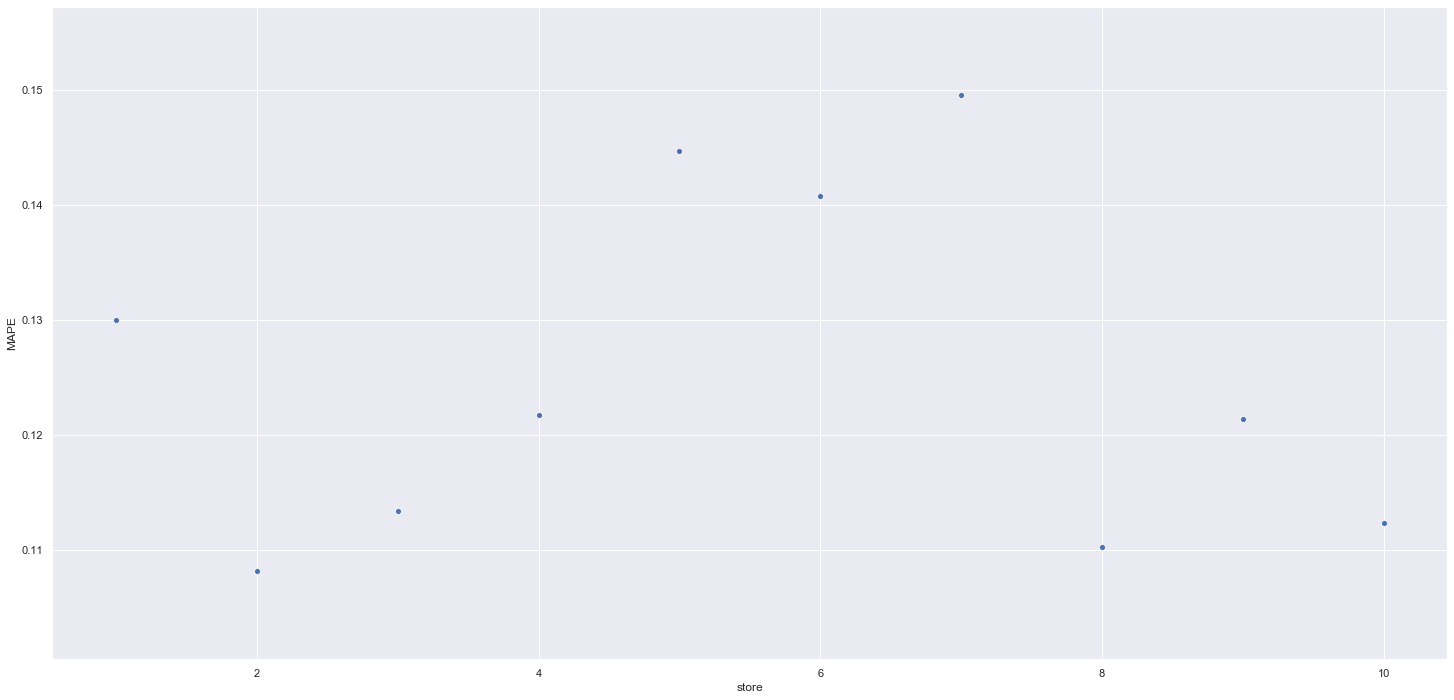

In [100]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

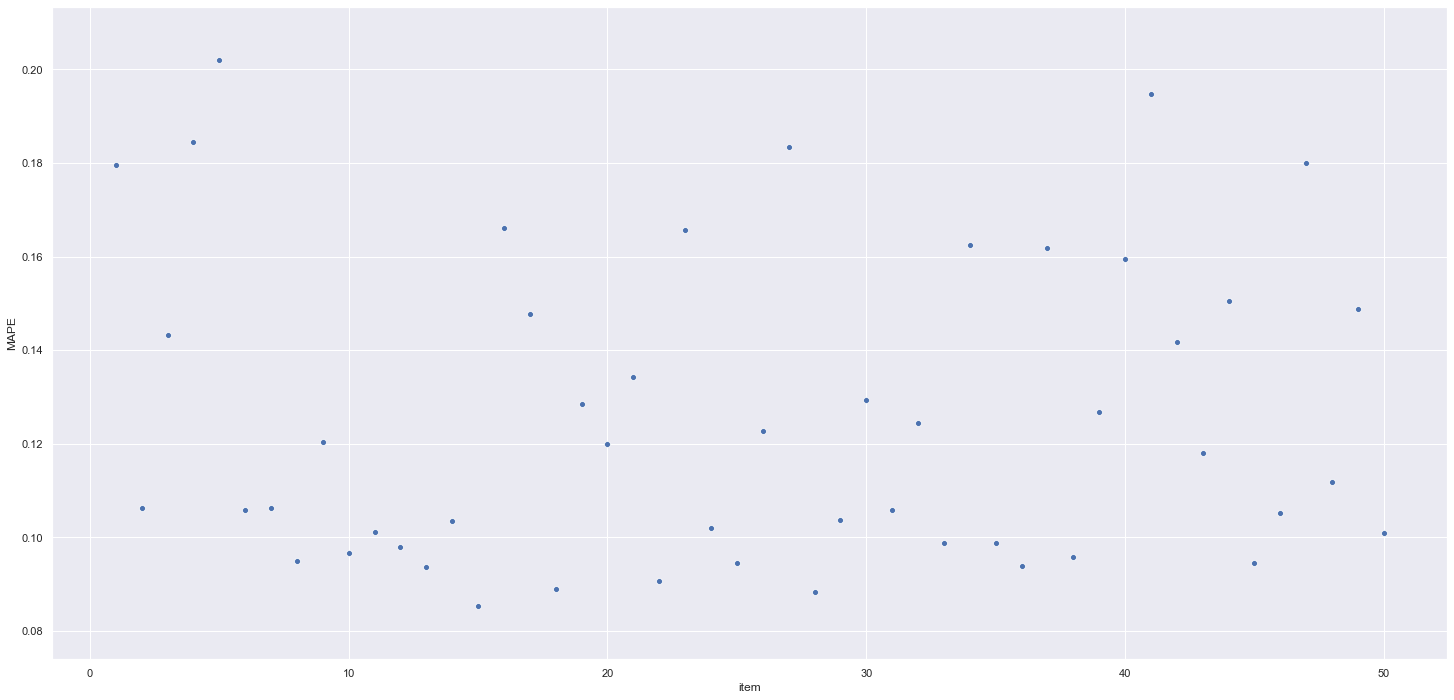

In [101]:
sns.scatterplot( x='item', y='MAPE', data=df94 )

## 9.2. Total Performance

In [107]:
df95 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values p Store'} )
df95['Values p Store'] = df95['Values p Store'].map( '{:,.2f} items'.format )
df95

,Scenario,Values p Store
0,predictions,"2,439,672.22 items"
1,worst_scenario,"2,439,614.25 items"
2,best_scenario,"2,439,673.47 items"


In [108]:
df96 = df94[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values p Item'} )
df96['Values p Item'] = df96['Values p Item'].map( '{:,.2f} items'.format )
df96

,Scenario,Values p Item
0,predictions,"2,439,672.23 items"
1,worst_scenario,"2,439,382.37 items"
2,best_scenario,"2,439,678.49 items"


## 9.3. Machine Learning Performance

In [139]:
df9_rf = X_test[ cols_selected_boruta_full ]

# rescale
df9_rf['sales'] = np.expm1( df9_rf['sales'] )
df9_rf['predictions'] = np.expm1( yhat_rf )

df9_rf['error'] = df9_rf['sales'] - df9_rf['predictions']
df9_rf['error_rate'] = df9_rf['predictions'] / df9_rf['sales']
df9_rf.head()

,store,item,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,date,sales,predictions,error,error_rate
1735,1,1,1.0,0.000000,1.000000,-0.866025,0.5,-0.992709,0.120537,2017-10-02,12.0,17.714393,-5.714393,1.476199
1736,1,1,1.0,0.781831,0.623490,-0.866025,0.5,-0.992709,0.120537,2017-10-03,18.0,23.482474,-5.482474,1.304582
1737,1,1,1.0,0.974928,-0.222521,-0.866025,0.5,-0.992709,0.120537,2017-10-04,15.0,18.718964,-3.718964,1.247931
1738,1,1,1.0,0.433884,-0.900969,-0.866025,0.5,-0.992709,0.120537,2017-10-05,20.0,22.085435,-2.085435,1.104272
1739,1,1,1.0,-0.433884,-0.900969,-0.866025,0.5,-0.992709,0.120537,2017-10-06,19.0,20.446208,-1.446208,1.076116


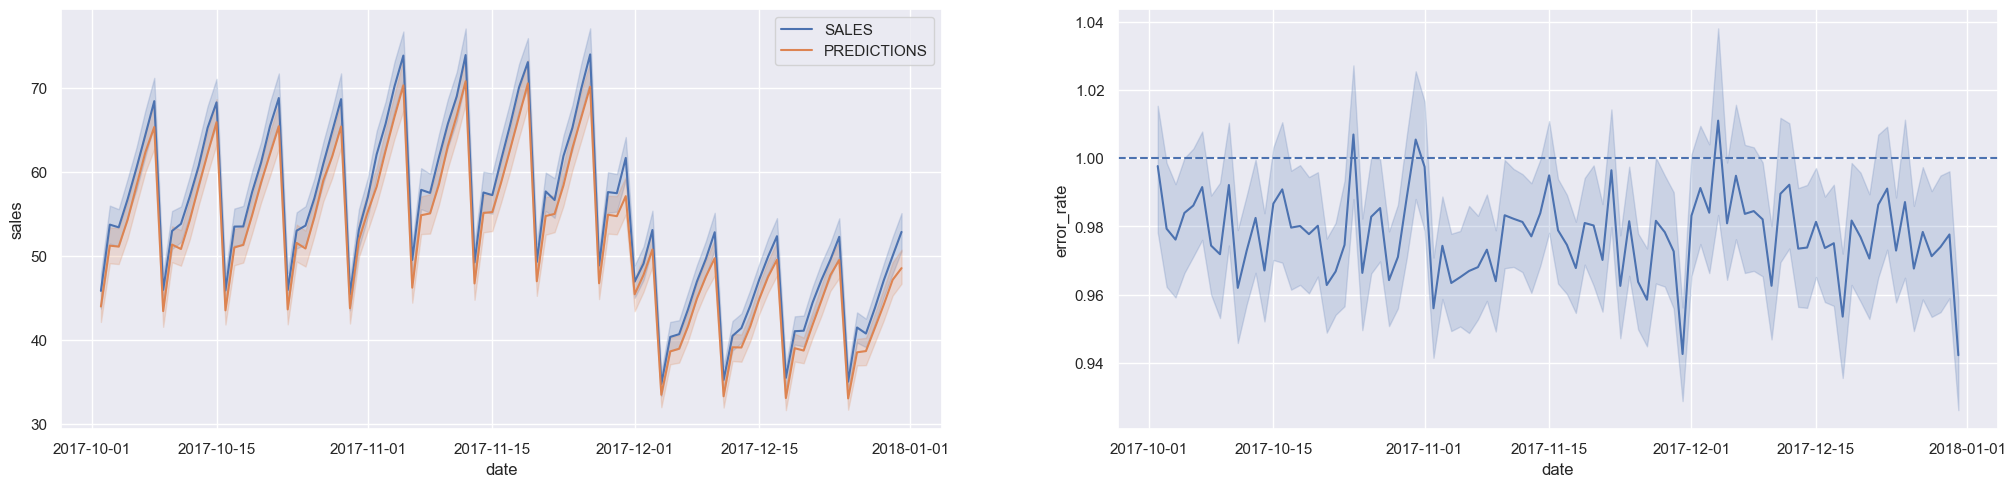

In [148]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9_rf, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9_rf, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9_rf )
plt.axhline( 1, linestyle='--' )

# plt.subplot( 2, 2, 3 )
# sns.distplot( df9_rf['error'] )

# plt.subplot( 2, 2, 4 )
# sns.scatterplot( df9_rf['predictions'], df9_rf['error'] )

In [141]:
df9_lrr = X_test[ cols_selected_boruta_full ]

# rescale
df9_lrr['sales'] = np.expm1( df9_lrr['sales'] )
df9_lrr['predictions'] = np.expm1( yhat_lrr )

df9_lrr['error'] = df9_lrr['sales'] - df9_lrr['predictions']
df9_lrr['error_rate'] = df9_lrr['predictions'] / df9_lrr['sales']
df9_lrr.head()

,store,item,year,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,date,sales,predictions,error,error_rate
1735,1,1,1.0,0.000000,1.000000,-0.866025,0.5,-0.992709,0.120537,2017-10-02,12.0,49.738885,-37.738885,4.144907
1736,1,1,1.0,0.781831,0.623490,-0.866025,0.5,-0.992709,0.120537,2017-10-03,18.0,46.405938,-28.405938,2.578108
1737,1,1,1.0,0.974928,-0.222521,-0.866025,0.5,-0.992709,0.120537,2017-10-04,15.0,47.843973,-32.843973,3.189598
1738,1,1,1.0,0.433884,-0.900969,-0.866025,0.5,-0.992709,0.120537,2017-10-05,20.0,53.262869,-33.262869,2.663143
1739,1,1,1.0,-0.433884,-0.900969,-0.866025,0.5,-0.992709,0.120537,2017-10-06,19.0,59.048370,-40.048370,3.107809


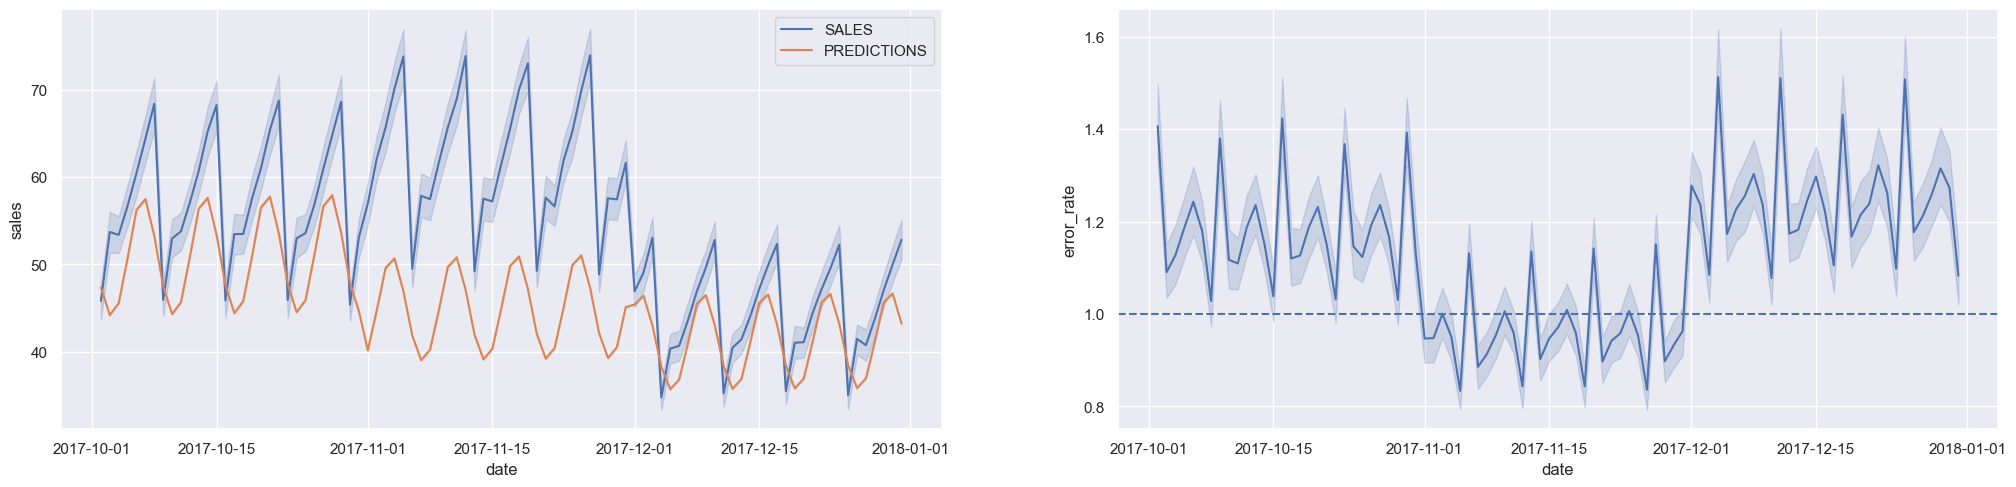

In [149]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9_lrr, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9_lrr, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9_lrr )
plt.axhline( 1, linestyle='--' )

# plt.subplot( 2, 2, 3 )
# sns.distplot( df9_lrr['error'] )

# plt.subplot( 2, 2, 4 )
# sns.scatterplot( df9_lrr['predictions'], df9_lrr['error'] )

In [130]:
df9_lr['error'] = df9_lr['sales'] - df9_lr['predictions']
df9_lr['error_rate'] = df9_lr['predictions'] / df9_lr['sales']

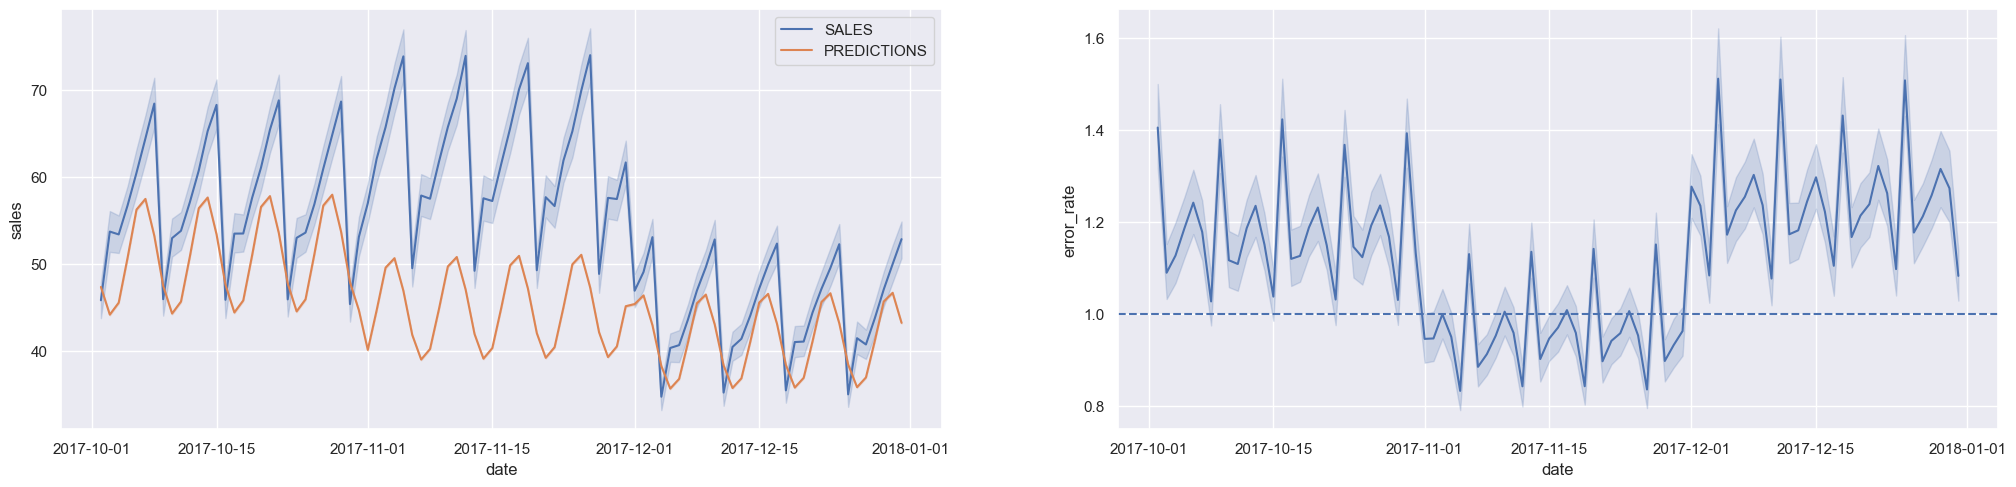

In [147]:
plt.subplot( 221 )
sns.lineplot( x='date', y='sales', data=df9_lr, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9_lr, label='PREDICTIONS' )

plt.subplot( 222 )
sns.lineplot( x='date', y='error_rate', data=df9_lr )
plt.axhline( 1, linestyle='--' )

# plt.subplot( 2, 2, 3 )
# sns.distplot( df9_lr['error'] )

# plt.subplot( 2, 2, 4 )
# sns.scatterplot( df9_lr['predictions'], df9_lr['error'] )

In [109]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

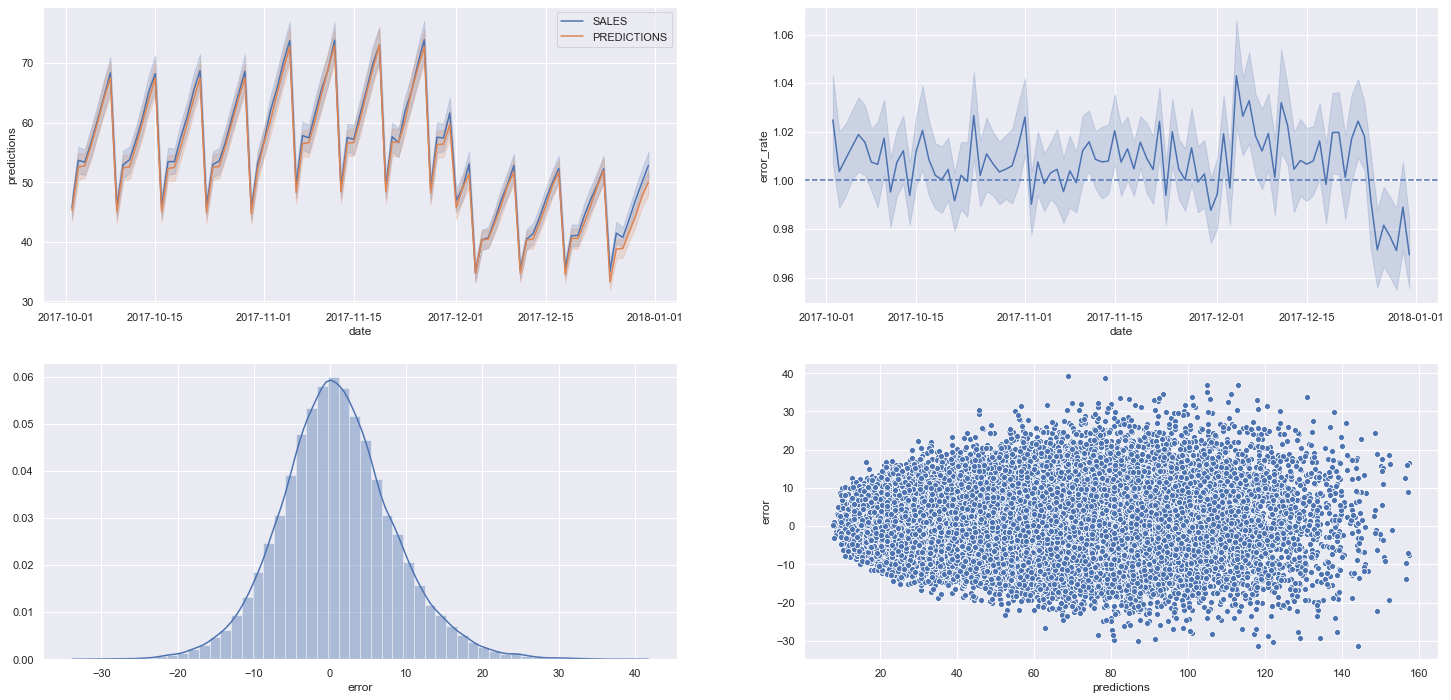

In [110]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )